<a href="https://colab.research.google.com/github/BLayus/MVP_Analise-de-Dados/blob/main/MVP_Analise_de_Dados_Credit_Card_Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando Bibliotecas e Datasets

In [ ]:
!pip install category_encoders

In [ ]:
# Import Libraries

import pandas as pd
import numpy as np
import datetime

# Data Viz Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import FuncFormatter
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Statistics and Statistical Tests
import statsmodels.api as sm
import scipy.stats
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from category_encoders import WOEEncoder

# ML Models
from sklearn.linear_model import LogisticRegression


In [ ]:
# Load Raw Dataset from Git Hub

df = pd.read_csv('https://raw.githubusercontent.com/BLayus/MVP_Analise-de-Dados/refs/heads/main/Data/Dataset_Fraud_Detection.csv')


In [ ]:
# Fazendo uma cópia do dataset inteiro do início.
# Isso Garante que eventuais tratamentos realizados durante a etaa de EDA não sejam transmitidos para a etapa de pré procesamento

df_pre = df.copy()

In [ ]:
# Show dataset sample

df.sample(5)


,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
107455,4,0.8930,2027559.94,2.0,0.000000,0.0,BR,4,Samsung Galaxy A10 Dual Sim 32 Gb Preto 2 Gb Ram,cat_43b9c10,0.062267,222.0,2.0,0,N,N,2020-03-21 15:10:15,158.14,99,0
9798,4,0.8171,78376.52,20.0,0.098366,339.0,BR,6,Ração Para Peixe Marinhos Tetra Marine Large F...,cat_45530a7,0.858724,3913.0,1134.0,1,NaN,Y,2020-04-06 10:23:27,11.74,67,0
41976,4,0.7193,98385.97,1.0,0.172626,16.0,BR,1,Kit 10 Colchonetes 90 X 44 X 3 Cm D23 Academi...,cat_0c2c00e,0.445656,1567.0,0.0,1,NaN,N,2020-03-11 15:30:38,39.88,32,0
27872,4,0.7809,5525.85,8.0,0.553159,2.0,BR,43,Almofada Para Amamentação - Travesseiro De Ama...,cat_cabe087,0.574336,2959.0,45.0,1,NaN,N,2020-04-07 13:24:20,12.58,52,0
17013,4,0.9449,171528.19,1.0,0.397993,26.0,BR,0,Cartão De Memória Sandisk Sdsquns-032g-gn3ma U...,cat_a2144eb,0.641817,1401.0,0.0,1,NaN,N,2020-03-25 8:14:05,5.92,81,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   score_1              150000 non-null  int64  
 1   score_2              137016 non-null  float64
 2   score_3              137016 non-null  float64
 3   score_4              149635 non-null  float64
 4   score_5              150000 non-null  float64
 5   score_6              149989 non-null  float64
 6   pais                 149806 non-null  object 
 7   score_7              150000 non-null  int64  
 8   produto              150000 non-null  object 
 9   categoria_produto    150000 non-null  object 
 10  score_8              150000 non-null  float64
 11  score_9              149989 non-null  float64
 12  score_10             149635 non-null  float64
 13  entrega_doc_1        150000 non-null  int64  
 14  entrega_doc_2        41143 non-null   object 
 15  entrega_doc_3    

## Dicionário de Dados

**score_1 a score_10**: São notas de bureau de crédito adquiridospara identificar a confiabilidade do comprador ou outros dados anonimizados sem informação especíifica.

**País**: país de compra.

**Produto**: produto que está sendo comprado no e-commerce.

**Categoria_produto**: categoria do produto.

**Entrega_doc_1 a entrega_doc_3**: Documentos necessários para fazer a conta. 0 = não entregou.  1 = entregou. Se vazio, considerar que nao entregou.

**Score_modelo**: score dado pelo modelo atual. Quanto mais próximo de 100, maior a probabilidade de fraude.

**Fraude**: Label inserido pós compra, identificando se a compra foi fraude ou não. 0 = Não Fraude. 1 = Fraude


## Hipóteses e Perguntas de Negócio

  * Qual o perfil das compras fraudadas? Elas ocorrem preferencialmente em quais horários, dias da semana, qual valor e com quais tipos de produtos?

  * Quais métricas podemos elaborar e utilizar para monitorar os prejuízos com fraudes?

  * Quais as features deste dataset que mais se relacionam às compras legítimas e fraudadas?

  * A partir destas informações, é possível esboçar um perfil do fraudador?

  * Quais seriam as estratégias e quais os modelos ideais de Machine Learning que poderiam contribuir para a diminuição de fraudes e como implantá-las?

In [ ]:
# Aplicando um plot style para os gráficos

#plt.style.use('seaborn-v0_8')

sns.set_style('darkgrid', {'grid.color': '.8',
                           'grid.linestyle': '-',
                           'text.color': '.2',
                           'xtick.color': 'dimgray',
                           'ytick.color': 'dimgray',
                           'axes.labelcolor': 'dimgray'})

# Definindo a paleta de cores
cor_fraudes= {0: "#4A90E2", 1: "#D9534F"}
colors = ['#4c94de', 'grey', 'cornflowerblue', 'silver', 'lightsteelblue', 'whitesmoke']
sns.set_palette(sns.color_palette(colors))

## Tratamento Inicial dos Dados

In [ ]:
# Reordenando colunas para manter as colunas "score" juntas, facilitando a leitura

df = df.reindex(columns= ['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
'score_7', 'score_8', 'score_9', 'score_10', 'entrega_doc_1',
'entrega_doc_2', 'entrega_doc_3', 'pais', 'produto', 'categoria_produto','data_compra',
'valor_compra', 'score_fraude_modelo', 'fraude'])


In [ ]:
# Acertando os dtypes, tipos de dados

# Trocando dtype da coluna data_compras

df["data_compra"] = pd.to_datetime(df["data_compra"], errors='coerce')



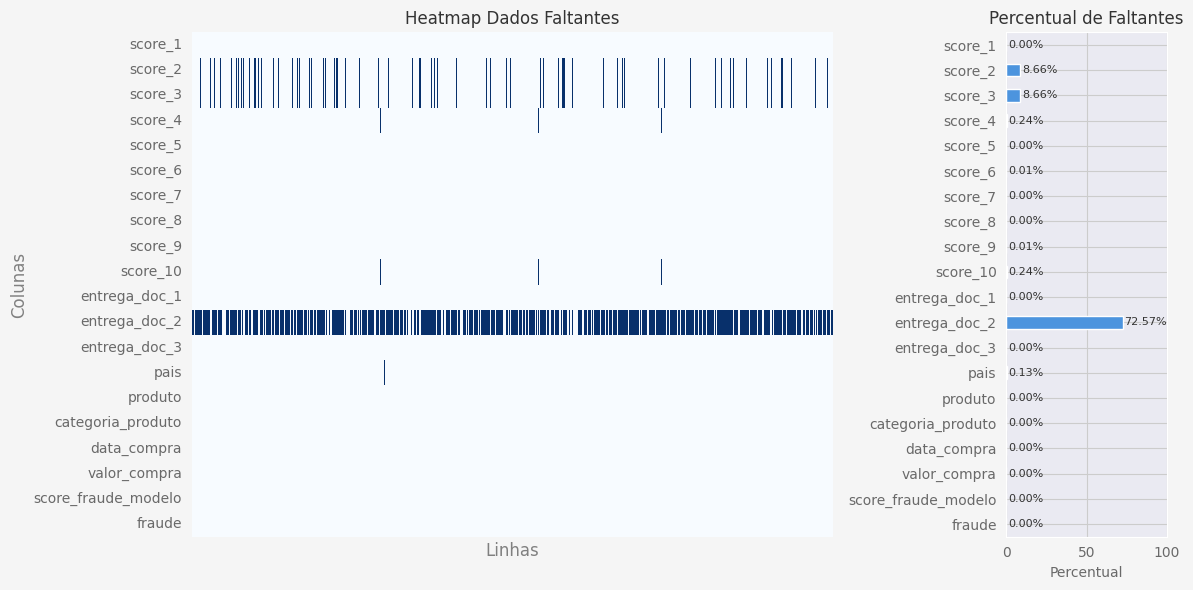

In [ ]:
# Plotando dados faltantes

def plot_missing_data(df):

  data_binary = df.isnull().astype(int)

  missing_perc = data_binary.mean().round(4) * 100

  fig, axes = plt.subplots(1, 2, figsize= (12, 6), gridspec_kw={'width_ratios': [4, 1]})
  ax1, ax2 = axes

  fig.patch.set_facecolor('#f5f5f5')
  ax1.set_facecolor('#f5f5f5')

  # Heatmap
  sns.heatmap(data_binary.T, cbar= False, ax= ax1, cmap= 'Blues')
  ax1.set_title("Heatmap Dados Faltantes")
  ax1.set_xlabel("Linhas", fontsize= 12, color= 'gray')
  ax1.set_ylabel("Colunas", fontsize= 12, color= 'gray')
  ax1.set_xticks([])

  # Percentuais faltantes por feature
  missing_perc.plot(kind= 'barh', ax= ax2)
  ax2.set_title("Percentual de Faltantes")
  ax2.set_xlabel("Percentual")
  ax2.set_xlim(0, 100)

  for i, t in enumerate(missing_perc):
    ax2.text(t + 1, i,  f'{t:.2f}%', va= 'center', fontsize= 8)

  ax2.invert_yaxis()

  plt.tight_layout()
  plt.show()

plot_missing_data(df)

In [ ]:
# Avaliação da quantidade de nulos em ordem descendente

display(df.isnull().sum().sort_values(ascending=False))


,0
entrega_doc_2,108857
score_2,12984
score_3,12984
score_4,365
score_10,365
pais,194
score_9,11
score_6,11
score_1,0
score_8,0


O dataset possui poucos valores nulos, principalmente concentrado na coluna "entrega_doc_2", com 108.857 nulos.

Há também  12.984 valores nulos nas colunas "score_2", "score_3" e em menor quantidade (365) nas colunas "score_4" e "score_10".

Alguns valores nulos (194) na coluna "País", que talvez possam ser preenchidos com base em uma outa coluna.

Alguns poucos nulos nas colunas "score_6" e "score_9" (11 em cada coluna).

In [ ]:
# Quantidade absoluta de dados e de nulos

display(f'O total de dados presentes neste conjunto é: {df.shape[0]}')

display(f'O total de dados faltantes neste conjunto é: {df.isna().sum().sum()}')


'O total de dados presentes neste conjunto é: 150000'

'O total de dados faltantes neste conjunto é: 135771'

In [ ]:
# Quantidade absoluta e percentual de dados e de nulos em cada coluna

display(f'Aproximadamente {round((df.entrega_doc_2.isna().sum()/ df.shape[0]) * 100, 1)}% das linhas de dados possuem a coluna "entrega_doc_2" nula')

display(f'Aproximadamente {round((df.score_2.isna().sum()/ df.shape[0]) * 100, 1)}% das linhas de dados possuem a coluna "score_2" ou "score_3" nula')

display(f'Aproximadamente {round((df.score_4.isna().sum()/ df.shape[0]) * 100, 1)}% das linhas de dados possuem a coluna "score_4" ou "score_10" nula')

display(f'Aproximadamente {round((df.pais.isna().sum()/ df.shape[0]) * 100, 1)}% das linhas de dados possuem a coluna "país" nula')



'Aproximadamente 72.6% das linhas de dados possuem a coluna "entrega_doc_2" nula'

'Aproximadamente 8.7% das linhas de dados possuem a coluna "score_2" ou "score_3" nula'

'Aproximadamente 0.2% das linhas de dados possuem a coluna "score_4" ou "score_10" nula'

'Aproximadamente 0.1% das linhas de dados possuem a coluna "país" nula'

  * Apenas a coluna "entrega_doc_2" apresenta um percentual alto de faltantes. É necessário confirmar se no decorrer da análise esta feature vai ou não estar fortemente relacionada ao perfil de fraudes.

  * O restante das colunas possuem percentual pequeno de dados faltantes e possivelmente não irão influenciar na análise.

## Análise das Variáveis

### Proporção de Fraudes

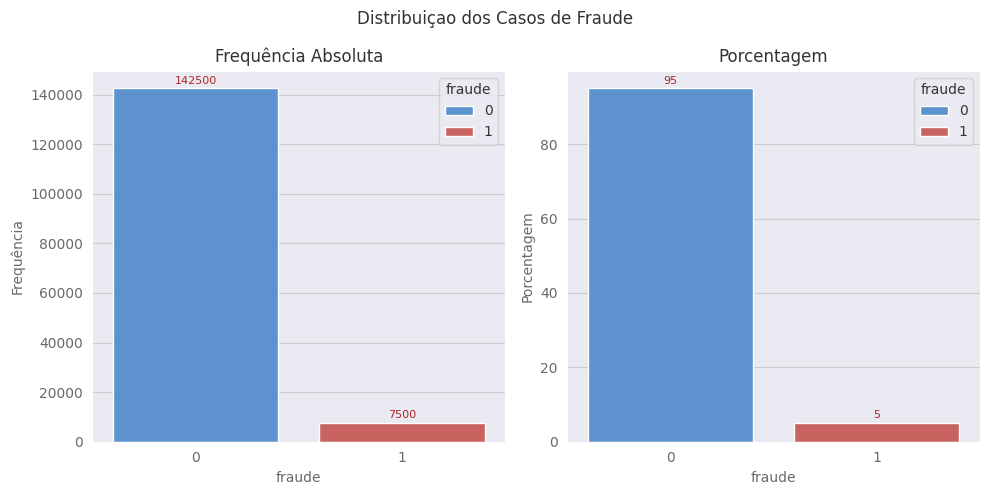

   fraude  Frequência  Porcentagem
0       0      142500         95.0
1       1        7500          5.0


In [ ]:
# Primeiro item a ser avaliado: Proporção de fraudes nas compras

dist_abs = df['fraude'].value_counts()
dist_percent = df['fraude'].value_counts(normalize=True) * 100

freq = pd.DataFrame({'Frequência':dist_abs, 'Porcentagem': dist_percent})
freq= freq.reset_index().rename(columns= {'index': 'fraude'})

fig, axes = plt.subplots(1,2, figsize=(10,5))
fig.suptitle('Distribuiçao dos Casos de Fraude')
axes[0].set_title('Frequência Absoluta')
axes[1].set_title('Porcentagem')
ax1 = sns.barplot(data= freq, x= 'fraude', y=freq['Frequência'], hue= 'fraude', palette= cor_fraudes, ax=axes[0])
ax2 = sns.barplot(data= freq, x= 'fraude', y=freq['Porcentagem'], hue= 'fraude', palette= cor_fraudes, ax=axes[1])

for c in ax1.containers:
  ax1.bar_label(c, fontsize= 8, color= 'firebrick', padding= 2)

for c in ax2.containers:
  ax2.bar_label(c, fontsize= 8, color= 'firebrick', padding= 2)

plt.tight_layout()
plt.show()
print(freq)


  * Das 150 mil linhas de dados deste conjunto, 7500 foram rotuladas como fraudes, o que significa 5% do total.

  * Trata-se de um dataset com forte desbalanceamento de classes, mais adiante será necessário pensar em estratégias para lidar com este tipo de desbalanceamento.

### Países

In [ ]:
# Analisando a coluna País

compra_pais = df['pais'].value_counts().reset_index().rename(columns={'pais': 'pais', 'count': 'contagem'})
compra_pais['perc_cum_compras'] = compra_pais['contagem'].cumsum()/compra_pais['contagem'].sum() * 100

display(compra_pais.head(5))


,pais,contagem,perc_cum_compras
0,BR,111628,74.515039
1,AR,31964,95.851969
2,UY,2967,97.832530
3,US,2273,99.349826
4,SE,358,99.588802


In [ ]:
# Analisando quantidade de fraudes por país

fraude_pais = df.groupby('pais')['fraude'].sum().sort_values(ascending= False).reset_index()
fraude_pais['perc_cum_fraudes'] = fraude_pais['fraude'].cumsum()/df['fraude'].sum() * 100

display(fraude_pais.head(5))

,pais,fraude,perc_cum_fraudes
0,BR,6162,82.160000
1,AR,1179,97.880000
2,US,70,98.813333
3,UY,29,99.200000
4,SE,15,99.400000


In [ ]:
# Juntando dataset contagem de países e fraudes por país

df_fraude_pais = pd.merge(compra_pais, fraude_pais, on= ['pais'], how= 'left')

df_fraude_pais[0:5]


,pais,contagem,perc_cum_compras,fraude,perc_cum_fraudes
0,BR,111628,74.515039,6162,82.160000
1,AR,31964,95.851969,1179,97.880000
2,UY,2967,97.832530,29,99.200000
3,US,2273,99.349826,70,98.813333
4,SE,358,99.588802,15,99.400000


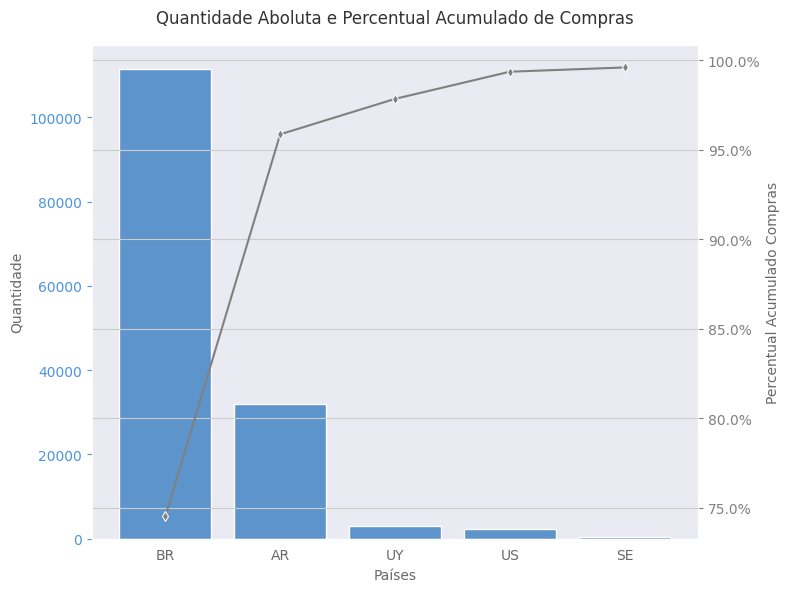

In [ ]:
# Plotando um  gráfico pareto com esta distribuição por países e soma cumulativa de transações

fig, ax = plt.subplots(figsize= (8, 6))
ax = sns.barplot(x=df_fraude_pais['pais'][0:5], y= df_fraude_pais['contagem'][0:5], color="C0")
ax2 = ax.twinx()
ax2= sns.lineplot(x= df_fraude_pais['pais'][0:5], y= df_fraude_pais['perc_cum_compras'][0:5], color="C1", marker="d", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

fig.suptitle("Quantidade Aboluta e Percentual Acumulado de Compras")
ax.grid(False)
ax.set_xlabel("Países")
ax.set_ylabel("Quantidade")
ax2.set_ylabel("Percentual Acumulado Compras")
ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

plt.tight_layout()
plt.show()

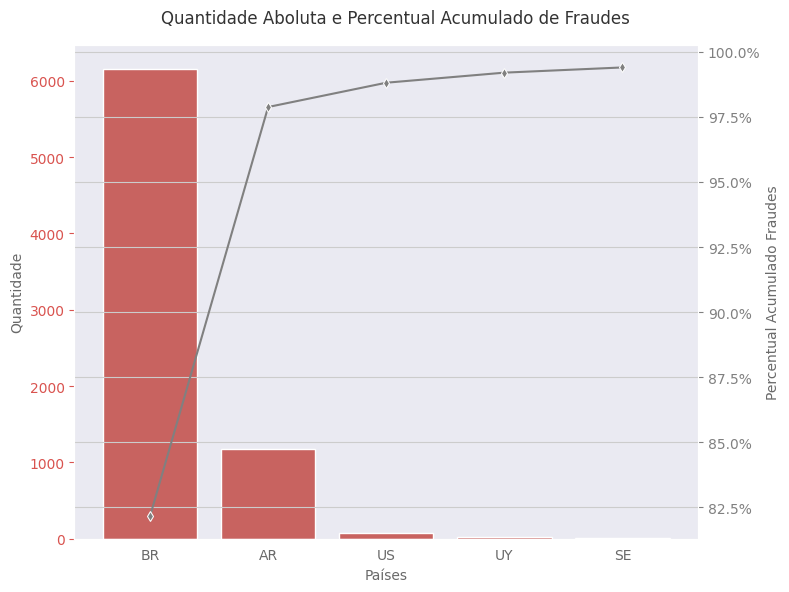

In [ ]:
# Plotando um  gráfico pareto com esta distribuição por países e cum sum total  de fraudes

df_fraude_pais = df_fraude_pais.sort_values('fraude', ascending=False).reset_index(drop=True)
df_fraude_pais['perc_cum_fraudes'] = df_fraude_pais['fraude'].cumsum()/df['fraude'].sum() * 100

fig, ax = plt.subplots(figsize= (8, 6))
ax = sns.barplot(x=df_fraude_pais['pais'][0:5], y= df_fraude_pais['fraude'][0:5], color=cor_fraudes[1])
ax2 = ax.twinx()
ax2= sns.lineplot(x= df_fraude_pais['pais'][0:5], y= df_fraude_pais['perc_cum_fraudes'][0:5], color="C1", marker="d", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

fig.suptitle("Quantidade Aboluta e Percentual Acumulado de Fraudes")
ax.grid(False)

ax.tick_params(axis="y", colors=cor_fraudes[1])
ax2.tick_params(axis="y", colors="C1")
ax.set_xlabel("Países")
ax.set_ylabel("Quantidade")
ax2.set_ylabel("Percentual Acumulado Fraudes")

plt.tight_layout()
plt.show()


  * Analisando o gráfico e as tabelas acima, constata-se que 74.5% das transações presentes neste dataset ocorreram no Brasil e 95.8 % de todas as transações aconteceram no Brasil e na Argentina.

  * Para fins de análise, é possível codificar esta coluna com muitas variáveis categóricas apenas com 3 valores (Brasil, Argentina e Outros) já que a quase totalidade das ftransações ocorreram nestes dois países e uma fração muito pequena ocorreu noes outros países.

  * O mesmo podemos constatar através do percentual de fraudes, onde aprox. 82% das fraudes ocorreram no Brasil e aprox. 98% das fraudes ocorreram no Brasil e na Argentina somadas.

  * Estas constatações reforçam a idéia de limitar a categorização dos países entre Brasil, Argentina e outros faz bastante sentido.
  

In [ ]:
# Alterando coluna país

df['pais'] = df['pais'].apply(lambda x: 'BR' if x == 'BR' else 'AR' if x == 'AR' else 'outros')


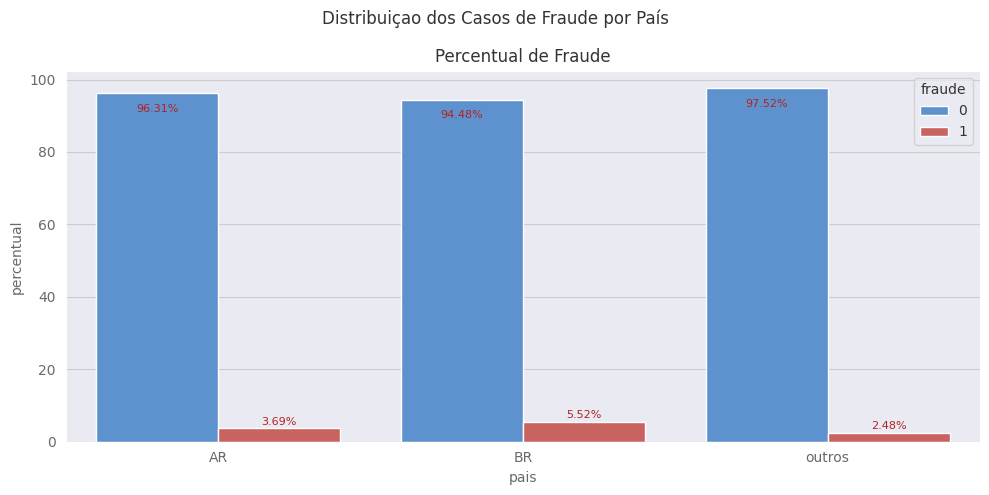

In [ ]:
# Plotando um gráfico para visualizar estes valores percentuais de fraude e não fraude por país

groups = pd.DataFrame(df.groupby('pais')[['pais', 'fraude']].value_counts(sort= True).reset_index(name= 'Quantidade'))
groups.pivot_table(columns= 'fraude', values='Quantidade')

filter_paises = groups.loc[groups['pais'].isin(['BR', 'AR', 'outros'])].copy()
filter_paises['percentual'] = filter_paises.groupby('pais', group_keys=False)['Quantidade'].apply(lambda x: x / x.sum() * 100)

fig, axes = plt.subplots(figsize=(10,5))
fig.suptitle('Distribuiçao dos Casos de Fraude por País')
axes.set_title('Percentual de Fraude')

ax1 = sns.barplot(x= 'pais', y= 'percentual', data= filter_paises, hue= 'fraude', palette= cor_fraudes)
ax1.bar_label(ax1.containers[0], fontsize= 8, color= 'firebrick', padding=-15, fmt='%.2f%%')
ax1.bar_label(ax1.containers[1], fontsize= 8, color= 'firebrick', padding=1, fmt='%.2f%%')

plt.tight_layout()
plt.show()

  * O Brasil lidera o ranking em percentual de fraudes, com aprox. **5.5%** de casos de fraude, quase o **dobro da média** da categoria "Outros".
  
  * Em segundo lugar está a Argentina, com **3.7%** de fraudes.

### Cardinalidade das Colunas

In [ ]:
# Análise da cardinalidade das colunas. Quanto mais valores únicos aparecem na coluna, maior a cardinalidade

cardinalidade = []
colunas = []

for x in df.columns:
  nome_col = x
  n_unique = df[x].nunique()
  colunas.append(nome_col)
  cardinalidade.append(n_unique)

df_cardinalidade = pd.DataFrame({'Coluna': colunas, 'Cardinalidade': cardinalidade})

df_cardinalidade

,Coluna,Cardinalidade
0,score_1,4
1,score_2,7672
2,score_3,135090
3,score_4,51
4,score_5,43207
5,score_6,1338
6,score_7,59
7,score_8,149999
8,score_9,7297
9,score_10,1793


  * A cardinalidade da coluna "País" já foi tratada, restando apenas três categorias.

  * A coluna "Score_1" possui apenas 4 valores diferentes, é possível tratá-la como uma coluna categórica já encodada com valores de 1 a 4.

  * A coluna "data_compra" possui 145 mil valores distintos, pois está no fortmato datetime, com data, hora, minuto e segundo.

  * As colunas "entrega_doc" 1 a 3 são colunas categóricas encodadas sim e não ou 0 e 1.

  * A coluna "score_8" possui 149.999 valores, um a menos do que o total de registros do dataset, por isso é uma coluna que não é útil para modelagem de machine learning. Ela varia tanto que não permite identificar nenhum padrão relacionado a outras features ou ao noso target.

  * A cardinalidade da coluna "produto" ser alta faz total sentido, pois cada compra tem sua particularidade e um market place normalmente oferece milhares de produtos diferentes, sendo assim não faz sentido mexer neste tipo de variável.

  * A coluna "categoria de produto" possui alta cardinalidade e, ainda por cima, as categorias estão em códigos que não permitem entender seu significado. Porém é provável que as fraudes estejam de alguma forma associadas a determinadas categorias, por isso minha estratégia será manter apenass as 100 ou no máximo 150 categorias que concentrem a maior parte das fraudes e chamar o restante de "outras".


### Categorias e Produtos

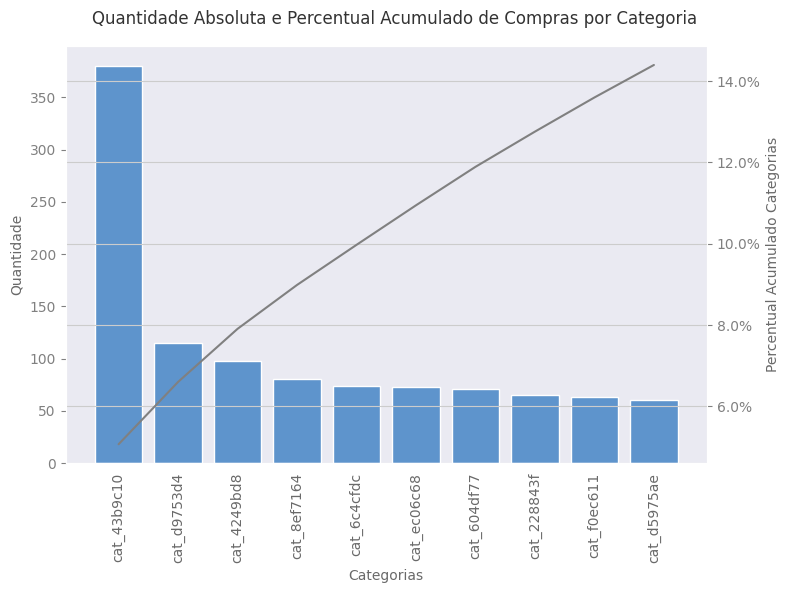

In [ ]:
# Plotando um gráfico de pareto relacionando fraudes e categorias


fraude_sort = df.loc[df['fraude'] == 1].groupby(['categoria_produto'])['fraude'].sum().reset_index()

fraude_sort = fraude_sort.sort_values(by= 'fraude', ascending= False)
fraude_sort['percent_cumsum'] = fraude_sort['fraude'].cumsum() / fraude_sort['fraude'].sum() * 100

fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.barplot(x= fraude_sort['categoria_produto'][0:10], y= fraude_sort['fraude'][0:10], color= 'C0')
ax2 = ax.twinx()
ax2 = sns.lineplot(x= fraude_sort['categoria_produto'][0:10], y= fraude_sort['percent_cumsum'][0:10], color= 'C1')
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.grid(False)

plt.suptitle("Quantidade Absoluta e Percentual Acumulado de Compras por Categoria")
ax.tick_params(axis="y", colors="C1")
ax2.tick_params(axis="y", colors="C1")
ax.tick_params(axis="x", labelrotation= 90)
ax.set_xlabel("Categorias")
ax.set_ylabel("Quantidade")
ax2.set_ylabel("Percentual Acumulado Categorias")

plt.tight_layout()
plt.show()


  * Apesar de as 10 categorias mais fraudadas não representarem a maioria das fraudes, quer dizer, as compras fraudadas estão distribuídas por várias categorias, visivelmente a categoria "cat_43b9c10" apresenta muito mais casos absolutos do que as restantes.

In [ ]:
# Vamos olhar apenas para os produtos das compras fraudadas dentro desta categoria

prod_cat_43b9c10 = df.loc[(df['fraude'] == 1) & (df['categoria_produto'] == 'cat_43b9c10')].groupby('produto')['fraude'].sum().sort_values(ascending=False)

display(prod_cat_43b9c10)

,fraude
produto,
Samsung Galaxy A30s Dual Sim 64 Gb Prism Crush White 4 Gb Ram,11
Xiaomi Redmi Note 8 Dual Sim 64 Gb Azul-netuno 4 Gb Ram,8
Samsung Galaxy A10 Dual Sim 32 Gb Preto 2 Gb Ram,6
Xiaomi Mi 8 Lite Dual Sim 64 Gb Midnight Black 4 Gb Ram,6
Samsung Galaxy A30s 64 Gb Prism Crush Black 4 Gb Ram,5
...,...
iPhone 6 16gb Desbloqueado Original Seminovo,1
iPhone 6 16gb-excelente Estado-con Caja Orginal-liberado,1
iPhone 6s 64gb Dourado Tela 4.7 Ios 9 4g 12mp - Apple,1


  * Como demonstrado acima, a categoria mais fraudada inclui vários tipos de telefones celulares. Parece importante ressaltar que a maioria destes casos de fraude desafiadores acontecem na compra de aparelhos telefônicos.

  * Vale investigar um pouco mais a fundo quais compras de outros produtos são mais frequentemente fraudados.

In [ ]:
# Existem categorias e produtos neste dataset que nunca foram objeto de fraudes?

com_fraude = df[df['fraude'] == 1] ['categoria_produto'].unique()

sem_fraude = df[~df['categoria_produto'].isin(com_fraude)]['categoria_produto'].unique()

print(f'Total de Categorias que nunca tiveram fraude: {len(sem_fraude)}')
print('Toal de Categorias com fraude:', len(com_fraude))

Total de Categorias que nunca tiveram fraude: 6365
Toal de Categorias com fraude: 1959


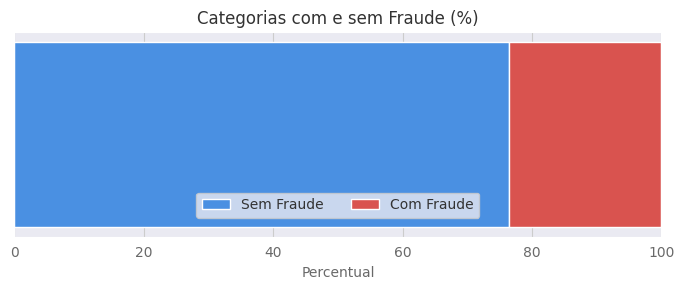

In [ ]:
# Plotar um gráfico de barras empilhadas na horizontal comparando categorias com e sem fraude

fraude = len(com_fraude)
n_fraude = len(sem_fraude)
total = fraude + n_fraude

perc_fraude= fraude / total * 100
perc_n_fraude= n_fraude / total * 100

fig, ax = plt.subplots(figsize= (8, 3))
ax.barh(y=[""], width=perc_n_fraude, color=cor_fraudes[0], label="Sem Fraude")
ax.barh(y=[""], width=perc_fraude, left=perc_n_fraude, color=cor_fraudes[1], label="Com Fraude")

ax.invert_yaxis()
ax.set_xlim(0, 100)
ax.set_xlabel("Percentual")
ax.set_ylabel("")
ax.set_title("Categorias com e sem Fraude (%)")
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0.25), ncol=2, frameon=True)

plt.subplots_adjust(left=0.1, right=0.3, top=0.3, bottom=0.1)
plt.tight_layout()
plt.show()

### Valor da Compra

In [ ]:
# Dentre as fraudes confirmadas como foram os valores das compras? Fraudes tendem a ter valores de compras mais altos ou mais baixos?

pedidos_fraudes = df.loc[df['fraude'] == 1]
pedidos_nao_fraudes = df.loc[df['fraude'] == 0]

print(f'A soma dos valores de compras não fraudadas foi: {pedidos_nao_fraudes.valor_compra.sum()}')
print(f'O valor médio de compras não fraudadas é: {round(pedidos_nao_fraudes.valor_compra.mean(),2)}')
print(f'O valor máximo é: {pedidos_nao_fraudes.valor_compra.max()}')
print(f'O valor mínimo é: {pedidos_nao_fraudes.valor_compra.min()}', '\n')

print(f'A soma dos valores de compras fraudadas foi: {pedidos_fraudes.valor_compra.sum()}')
print(f'O valor médio de compras fraudadas é: {round(pedidos_fraudes.valor_compra.mean(), 2)}')
print(f'O valor máximo é: {pedidos_fraudes.valor_compra.max()}')
print(f'O valor mínimo é: {pedidos_fraudes.valor_compra.min()}')


A soma dos valores de compras não fraudadas foi: 5981199.0
O valor médio de compras não fraudadas é: 41.97
O valor máximo é: 3696.35
O valor mínimo é: 0.02 

A soma dos valores de compras fraudadas foi: 547271.12
O valor médio de compras fraudadas é: 72.97
O valor máximo é: 3424.81
O valor mínimo é: 0.21


In [ ]:
# Cálculo do Basis points

bps = (pedidos_fraudes['valor_compra'].sum() / pedidos_nao_fraudes['valor_compra'].sum()) * 10000

print(f'O Basis Points (bps) deste conjunto de dados é de {bps:.2f}')


O Basis Points (bps) deste conjunto de dados é de 914.99


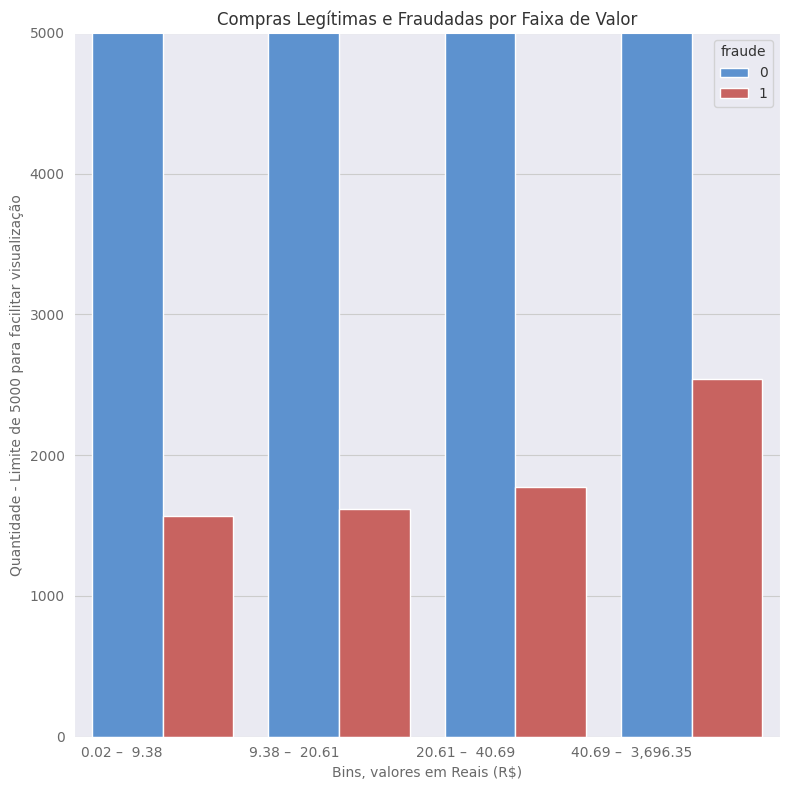

In [ ]:
# Para uma análise visual mais interessante, vou binarizar (transformar em faixas de valores ou 'Bins') os preços e comparar fraudes X não fraudes
# Iniciando com uma discretização baseada em percentis (qcut)

bins = pd.qcut(df['valor_compra'], 4)

# Create a DataFrame for plotting
plot_data = pd.DataFrame({'valor_compra_bin': bins, 'fraude': df['fraude']})

fig, ax= plt.subplots(figsize=(8, 8))
ax= sns.countplot(x= 'valor_compra_bin', hue= 'fraude', palette= cor_fraudes, data= plot_data)

ax.set_title('Compras Legítimas e Fraudadas por Faixa de Valor')
ax.set_xlabel("Bins, valores em Reais (R$)")
ax.set_ylabel("Quantidade - Limite de 5000 para facilitar visualização")
xticks = ax.get_xticks()
formatted_labels = [f"{interval.left:,.2f} –  {interval.right:,.2f}" for interval in bins.cat.categories]
ax.set_xticks(xticks)
ax.set_xticklabels(formatted_labels, rotation=0, ha='right')
ax.set_ylim(0, 5000)

plt.tight_layout()
plt.show()

  * Parece haver uma ligeira tendência de maior quantidade de fraudes em compras pertencentes ao 4o quartil.
  * É possível investigar mais a fundo usando dois gráficos que mostram o percentual de compras por faixa de valor e outro mostrando o percentual de fraudes por faixa de valor.

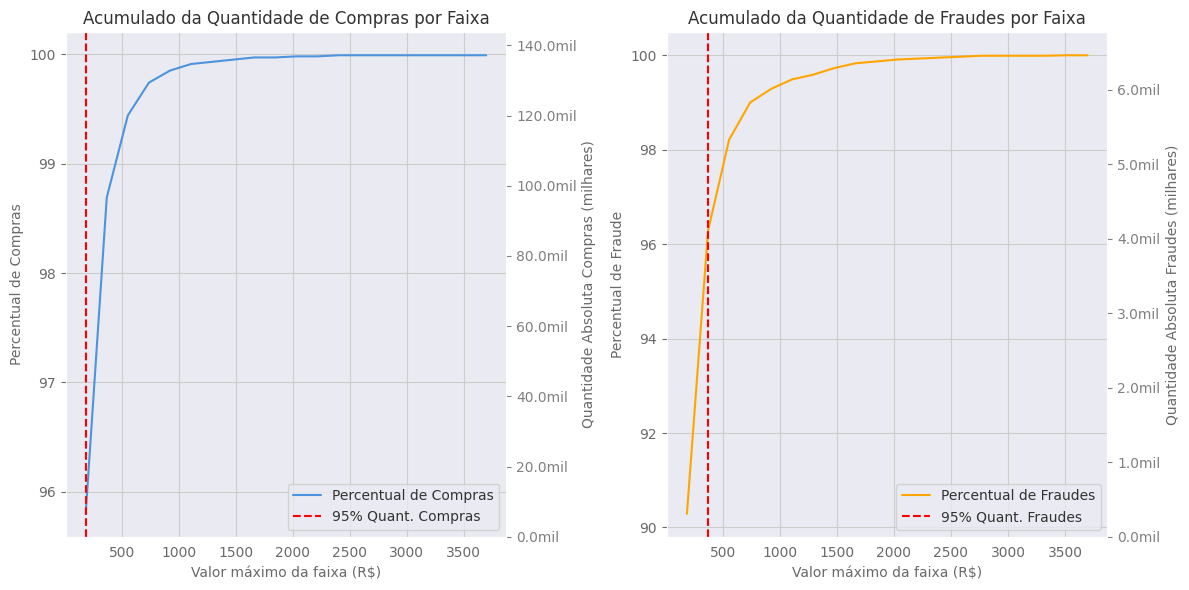

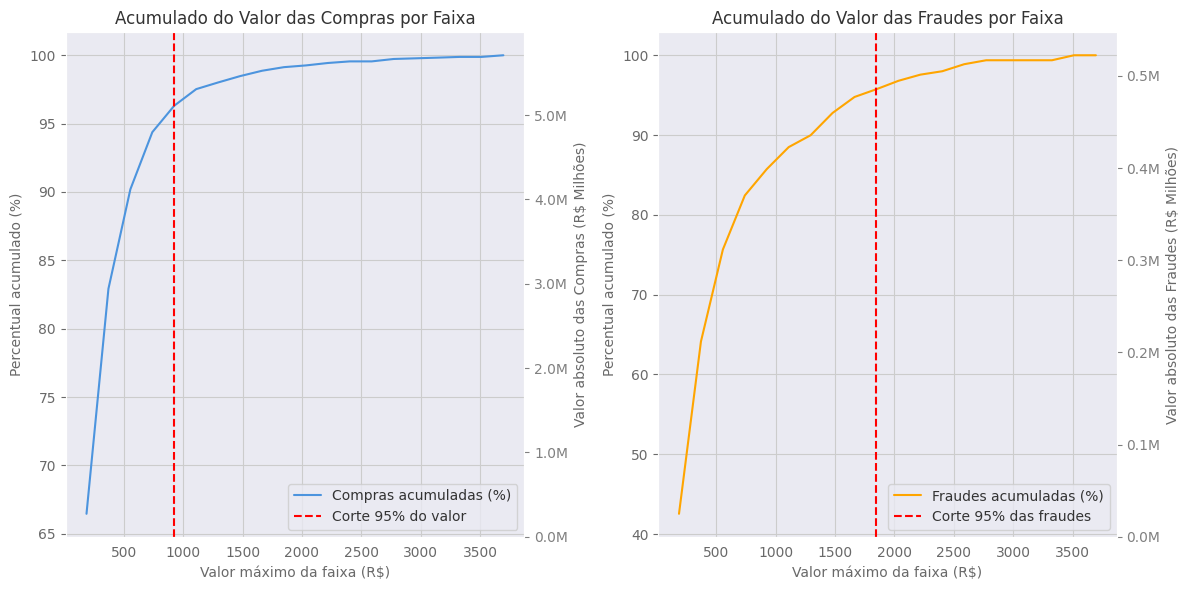

In [ ]:
# Analisando faixas de compras e fraudes

estat_compras = []
cum_sum, fraud_cum_sum = 0, 0
valor_sum, valor_sum_fraude = 0, 0

bins = 20
min_val = df["valor_compra"].min()
max_val = df["valor_compra"].max()
intervalos = np.linspace(min_val, max_val, bins + 1)

for x0, x1 in zip(intervalos[:-1], intervalos[1:]):
    name = f"{round(x0, 2)} - {round(x1, 2)}"

    df_range = df[(df["valor_compra"] > x0) & (df["valor_compra"] <= x1)]
    count = len(df_range)
    fraud_count = df_range['fraude'].sum()

    valor_compras = df_range[df_range['fraude'] == 0]['valor_compra'].sum()
    valor_fraudes = df_range[df_range['fraude'] == 1]['valor_compra'].sum()

    cum_sum += count
    fraud_cum_sum += fraud_count
    valor_sum += valor_compras
    valor_sum_fraude += valor_fraudes

    estat_compras.append({
        "range": name,
        "max_valor_bin": x1,

        "quantidade": count, # quantidade de compras legítimas
        "percentual_compras": round(100 * count / len(df['valor_compra']), 2),
        "compras_sum_percentual": round(100 * cum_sum / len(df['valor_compra']), 2),

        "$_sum_compras": valor_compras, # valor soma da faixa
        "$_cum_compras": valor_sum, # cumulativo

        "fraude_count": fraud_count, # quantidade de compras fraudadas
        "fraude_percentual": round(100 * fraud_count / df['fraude'].sum() if df['fraude'].sum() else 0, 2),
        "fraude_sum_percentual": round(100 * fraud_cum_sum / df['fraude'].sum() if df['fraude'].sum()else 0, 2),

        "$_sum_fraudes": valor_fraudes, # valor soma da faixa
        "$_cum_fraudes": valor_sum_fraude, # cumulativo

        "receita_faixa": 0.10 * valor_compras, # Receita 10% do valor das compras
        "lucro_liq_faixa": 0.10 * valor_compras  - valor_fraudes, # lucro de 10% sobre cada compra legítima

    })

df_sumario = pd.DataFrame(estat_compras). set_index('range')


# Plotando gráficos de QUANTIDADE X percentual de compras e fraudes

filtered_compras = df_sumario[df_sumario['compras_sum_percentual'] >= 95]
corte_compras = filtered_compras.iloc[0]['max_valor_bin'] if not filtered_compras.empty else None

filtered_fraudes = df_sumario[df_sumario['fraude_sum_percentual'] >= 95]
corte_fraudes = filtered_fraudes.iloc[0]['max_valor_bin'] if not filtered_fraudes.empty else None


fig, axes = plt.subplots(1, 2, figsize= (12, 6))
plt.subplots_adjust(wspace= 1)
ax1, ax2 = axes

ax1.plot(df_sumario['max_valor_bin'], df_sumario['compras_sum_percentual'], label= 'Percentual de Compras')
if corte_compras is not None:
    ax1.axvline(corte_compras, color='red', linestyle='--', label='95% Quant. Compras')
ax1.set_title("Acumulado da Quantidade de Compras por Faixa")
ax1.set_xlabel("Valor máximo da faixa (R$)")
ax1.set_ylabel("Percentual de Compras")

ax1b = ax1.twinx()
ax1b.set_ylabel("Quantidade Absoluta Compras (milhares)")
ax1b.set_ylim(0, df_sumario["quantidade"].max())
ax1b.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e-3:.1f}mil'))
ax1b.tick_params(axis='y', colors='gray')
ax1b.grid(False)

ax1.legend(loc="lower right")

ax2.plot(df_sumario["max_valor_bin"], df_sumario["fraude_sum_percentual"], label= 'Percentual de Fraudes', color= 'orange')
if corte_fraudes is not None:
    ax2.axvline(corte_fraudes, color='red', linestyle='--', label='95% Quant. Fraudes')
ax2.set_title("Acumulado da Quantidade de Fraudes por Faixa")
ax2.set_xlabel("Valor máximo da faixa (R$)")
ax2.set_ylabel("Percentual de Fraude")

ax2b = ax2.twinx()
ax2b.set_ylabel("Quantidade Absoluta Fraudes (milhares)")
ax2b.set_ylim(0, df_sumario["fraude_count"].max())
ax2b.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e-3:.1f}mil'))
ax2b.tick_params(axis='y', colors='gray')
ax2b.grid(False)

ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()


# Plotando gráfico de quantidade X percentual do VALOR das compras e fraudes

# Calculo percentuais
df_sumario["valor_acumulado_compras_percentual"] = 100 * df_sumario["$_cum_compras"] / df[df["fraude"] == 0]["valor_compra"].sum()
df_sumario["valor_acumulado_fraudes_percentual"] = 100 * df_sumario["$_cum_fraudes"] / df[df["fraude"] == 1]["valor_compra"].sum()

# Linha de corte em 95%
filtered_valor_compras = df_sumario[df_sumario["valor_acumulado_compras_percentual"] >= 95]
corte_valor_compras = filtered_valor_compras.iloc[0]["max_valor_bin"] if not filtered_valor_compras.empty else None

filtered_valor_fraudes = df_sumario[df_sumario["valor_acumulado_fraudes_percentual"] >= 95]
corte_valor_fraudes = filtered_valor_fraudes.iloc[0]["max_valor_bin"] if not filtered_valor_fraudes.empty else None


fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plt.subplots_adjust(wspace= 1)
ax1, ax2 = axes

ax1.plot(df_sumario["max_valor_bin"], df_sumario["valor_acumulado_compras_percentual"], label='Compras acumuladas (%)')
if corte_valor_compras is not None:
    ax1.axvline(corte_valor_compras, color='red', linestyle='--', label='Corte 95% do valor')
ax1.set_title("Acumulado do Valor das Compras por Faixa")
ax1.set_xlabel("Valor máximo da faixa (R$)")
ax1.set_ylabel("Percentual acumulado (%)")

ax1b = ax1.twinx()
ax1b.set_ylabel("Valor absoluto das Compras (R$ Milhões)")
ax1b.set_ylim(0, df_sumario["$_cum_compras"].max())
ax1b.tick_params(axis='y', colors='gray')
ax1b.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))
ax1b.grid(False)

ax1.legend(loc="lower right")

# Plotando valor acumulado de fraudes

ax2.plot(df_sumario["max_valor_bin"], df_sumario["valor_acumulado_fraudes_percentual"], label='Fraudes acumuladas (%)', color='orange')
if corte_valor_fraudes is not None:
    ax2.axvline(corte_valor_fraudes, color='red', linestyle='--', label='Corte 95% das fraudes')
ax2.set_title("Acumulado do Valor das Fraudes por Faixa")
ax2.set_xlabel("Valor máximo da faixa (R$)")
ax2.set_ylabel("Percentual acumulado (%)")

ax2b = ax2.twinx()
ax2b.set_ylabel("Valor absoluto das Fraudes (R$ Milhões)")
ax2b.set_ylim(0, df_sumario["$_cum_fraudes"].max())
ax2b.tick_params(axis='y', colors='gray')
ax2b.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x*1e-6:.1f}M'))
ax2b.grid(False)

ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

  * Como podemos observar nos gráficos acima, a quase totalidade das compras deste conjunto de dados (mais de 95\% das compras) são de itens abaixo de R\$ 500. A linha vermelha tracejada delimita o ponto de corte dos 95% das compras, em quantidade, não em valor.

  * Ao mesmo ocorre com as fraudes, sendo mais de 95\% delas em compras de valores abaixo de R\$ 500. O mesmo critério da linha de corte foi usado, ou seja: quantidade de eventos, não o valor acumulado das compras.

  * Quando avaliamos o valor envolvido nas compras legítimas e nas compras fraudadas, é possível perceber que 95% do valor total ocorreu em na faixa de valor até próximo de R\$ 1000. Quando olhamos para os valores de compras fraudadas, 95\% do valor acumulado se distribui até a faixa de aproximadamente R\$ 2000.

  * Porém, para compreender com mais precisão, é preciso explorar quanto foi efetivamente perdido com fraudes e em qual faixa de valor as perdas foram mais frequentes e mais custosas.

In [ ]:
df_sumario

,max_valor_bin,quantidade,percentual_compras,compras_sum_percentual,$_sum_compras,$_cum_compras,fraude_count,fraude_percentual,fraude_sum_percentual,$_sum_fraudes,$_cum_fraudes,receita_faixa,lucro_liq_faixa,valor_acumulado_compras_percentual,valor_acumulado_fraudes_percentual
range,,,,,,,,,,,,,,,
0.02 - 184.84,184.8365,143698,95.80,95.80,3975187.77,3975187.77,6772,90.29,90.29,232820.19,232820.19,397518.777,164698.587,66.461386,42.542020
184.84 - 369.65,369.6530,4337,2.89,98.69,984517.30,4959705.07,449,5.99,96.28,118125.88,350946.07,98451.730,-19674.150,82.921586,64.126547
369.65 - 554.47,554.4695,1126,0.75,99.44,435143.54,5394848.61,145,1.93,98.21,63102.13,414048.20,43514.354,-19587.776,90.196775,75.656870
554.47 - 739.29,739.2860,454,0.30,99.74,249919.49,5644768.10,59,0.79,99.00,37079.72,451127.92,24991.949,-12087.771,94.375193,82.432254
739.29 - 924.1,924.1025,163,0.11,99.85,115859.05,5760627.15,22,0.29,99.29,18067.69,469195.61,11585.905,-6481.785,96.312247,85.733669
924.1 - 1108.92,1108.9190,87,0.06,99.91,72407.71,5833034.86,15,0.20,99.49,15085.33,484280.94,7240.771,-7844.559,97.522835,88.490133
1108.92 - 1293.74,1293.7355,31,0.02,99.93,29216.77,5862251.63,7,0.09,99.59,8153.01,492433.95,2921.677,-5231.333,98.011312,89.979890
1293.74 - 1478.55,1478.5520,31,0.02,99.95,27695.60,5889947.23,11,0.15,99.73,15285.23,507719.18,2769.560,-12515.670,98.474357,92.772880
1478.55 - 1663.37,1663.3685,22,0.01,99.97,23463.93,5913411.16,7,0.09,99.83,10941.40,518660.58,2346.393,-8595.007,98.866651,94.772145


In [ ]:
# Valor em Reais que divide 95% das compras legítimas

faixa_95_legitima = df_sumario[df_sumario['compras_sum_percentual'] >= 95].iloc[0]
print(f"95% das compras ocorrem na faixa: {faixa_95_legitima.name}")
print(f"Valor limite: R$ {faixa_95_legitima['max_valor_bin']:.2f}\n")

# Valor em Reais que divide 95% das compras fraudadas

faixa_95_fraude = df_sumario[df_sumario['fraude_sum_percentual'] >= 95].iloc[0]
print(f"95% das fraudes ocorrem na faixa: {faixa_95_fraude.name}")
print(f"Valor limite: R$ {faixa_95_fraude['max_valor_bin']:.2f}\n")

# Análise top 5 faixas com mais compras

print("Top 5 faixas com mais compras:")
print(df_sumario.nlargest(5, 'quantidade')[['quantidade', 'percentual_compras', '$_cum_compras', 'valor_acumulado_compras_percentual']], "\n")

# Análise top 5 faixas com mais fraudes

print("Top 5 faixas com mais fraudes:")
print(df_sumario.nlargest(5, 'fraude_count')[['fraude_count', 'fraude_percentual', '$_cum_fraudes', "valor_acumulado_fraudes_percentual"]])


95% das compras ocorrem na faixa: 0.02 - 184.84
Valor limite: R$ 184.84

95% das fraudes ocorrem na faixa: 184.84 - 369.65
Valor limite: R$ 369.65

Top 5 faixas com mais compras:
                 quantidade  percentual_compras  $_cum_compras  \
range                                                            
0.02 - 184.84        143698               95.80     3975187.77   
184.84 - 369.65        4337                2.89     4959705.07   
369.65 - 554.47        1126                0.75     5394848.61   
554.47 - 739.29         454                0.30     5644768.10   
739.29 - 924.1          163                0.11     5760627.15   

                 valor_acumulado_compras_percentual  
range                                                
0.02 - 184.84                             66.461386  
184.84 - 369.65                           82.921586  
369.65 - 554.47                           90.196775  
554.47 - 739.29                           94.375193  
739.29 - 924.1                    

  * A faixa de valores que vai até R\$ 184,84 acumula 95\% das compras legítimas e quase R\$ 4 milhões em valor de compras, o que representa aproximadamente 83% do valor total de compras legítimas.

  * Embora a faixa de valores que vai até R\$ 369,65 acumule em torno de 96% das compras fraudadas, o valor total envolvido chega a R\$ 350 mil, o que representa pouco mais de 64% do valor total de compras fraudadas.

  * O maior faturamento em compras legítimas ocorre na faixa de preço até aproximadamente R\$ 185.

  * Embora a maioria das fraudes ocorram nesta faixa de valor até aproximadamente R\$ 370, o prejuízo causado por estas compras é de pouco mais de 65% do total. Ou seja: compras fraudadas em faixas de valores mais altas, apesar de serem em torno de 5%, representam uma grande parte do prejuízo causado à empresa.

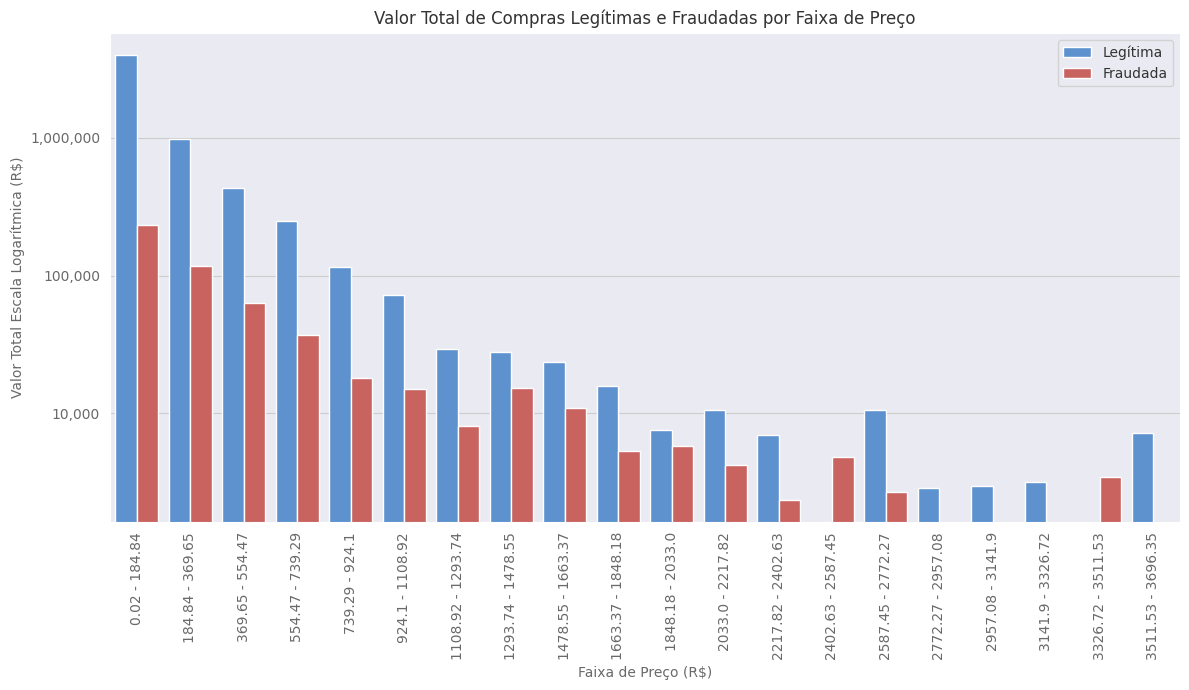

In [ ]:
# Qual o valor exato do prejuízo causado por fraudes em cada faixa de valores?

df_comparativo = df_sumario[['$_sum_compras', '$_sum_fraudes', 'lucro_liq_faixa']].reset_index()

df_melted = df_comparativo.melt(id_vars='range', value_vars=['$_sum_compras', '$_sum_fraudes'], var_name='Purchase Type', value_name='Total Value')

df_melted['Purchase Type'] = df_melted['Purchase Type'].replace({'$_sum_compras': 'Legítima', '$_sum_fraudes': 'Fraudada'})


plt.figure(figsize=(12, 7))
ax = sns.barplot(x='range', y='Total Value', hue='Purchase Type', data=df_melted, palette= ["#4A90E2", "#D9534F"])

ax.set_xlabel("Faixa de Preço (R$)")
ax.set_ylabel("Valor Total Escala Logarítmica (R$)")
ax.set_title("Valor Total de Compras Legítimas e Fraudadas por Faixa de Preço")

ax.set_yscale('log')
ax.tick_params(axis='x', rotation=90)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

ax.legend( loc='upper right')

plt.tight_layout()
plt.show()


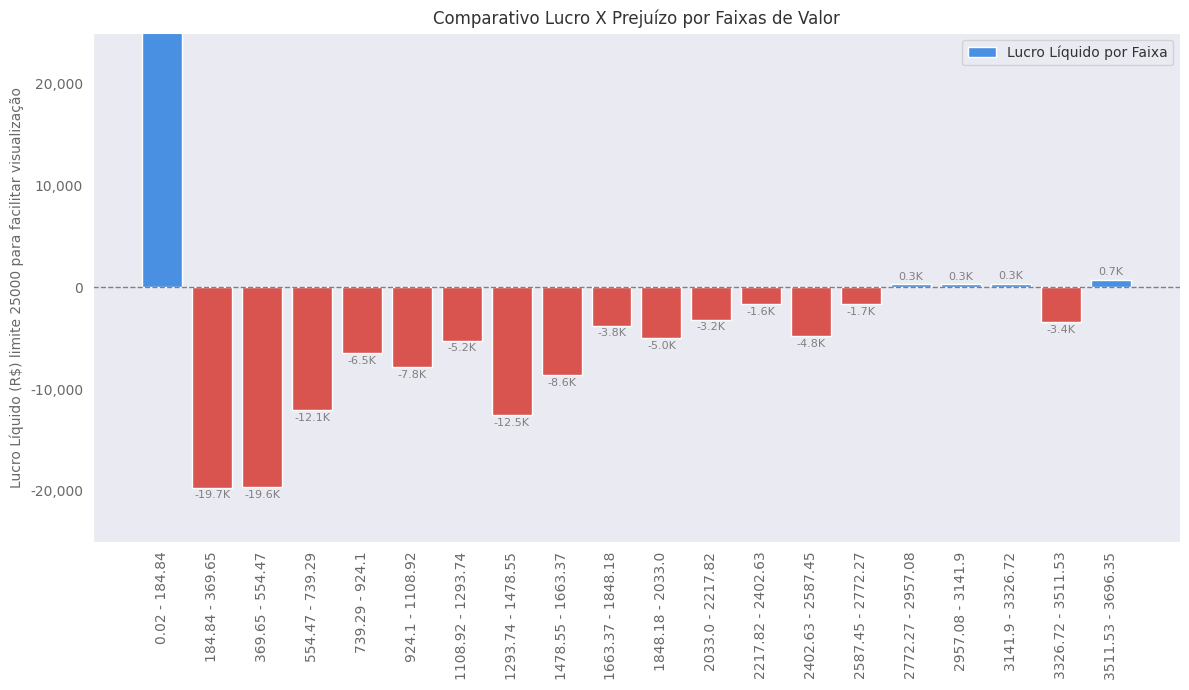

In [ ]:
# Plotando gráfico relacionando lucro X prejuízo em cada faixa de valor

fig, ax = plt.subplots(figsize=(12,7))
lucros = df_comparativo['lucro_liq_faixa'].values

cores= ["#4A90E2" if v > 0 else "#D9534F" for v in lucros]

ax.bar(df_comparativo['range'], lucros, color= cores, label='Lucro Líquido por Faixa')
ax.set_ylabel("Lucro Líquido (R$) limite 25000 para facilitar visualização")
ax.axhline(0, color='gray', linestyle='--', linewidth=1)

ax.set_title("Comparativo Lucro X Prejuízo por Faixas de Valor")
ax.tick_params(axis='x', rotation=90)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}'))

ax.bar_label(ax.containers[0], fontsize= 8, color= 'C1', padding=2, fmt= (lambda x: f'{x*1e-3:.1f}K'))

ax.grid(False)
ax.set_ylim(-25000, 25000)
ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
receita = df[df['fraude'] == 0]['valor_compra'].sum() * 0.1
perda = df[df['fraude'] == 1]['valor_compra'].sum()

lucro_final = receita - perda

print(f'A receita total com compras legítimas (10% do valor da compra) foi de R$ {receita}\n')
print(f'A perda total com compras fraudadas (valor da compra fraudada) foi de R$ {perda}\n')
print(f'O Lucro Líquido Final foi de R$ {round(lucro_final, 2)}')


A receita total com compras legítimas (10% do valor da compra) foi de R$ 598119.9

A perda total com compras fraudadas (valor da compra fraudada) foi de R$ 547271.12

O Lucro Líquido Final foi de R$ 50848.78


  * De acordo com os dados e gráficos acima, em quase todas as faixas de preço as perdas com fraudes superaram o lucro obtido.

  * A faixa que obteve lucro mais expressivo foi a primeira faixa de preços, até 184 reais. E a faixa ded reço que mais trouxe prejuízo foi a segunda faixa, de 184 a 370 reais.

  * No computo final, entre todas as transações legítimas, a empresa obteve aproximadamente R\$ 600 mil (10% do valor das compras). Porém as perdas com fraudes chegaram a R\$ 547 mil. O lucro líquido obtido foi de apenass R\$ 50 mil.

  * De uma movimentação de aproximadamennte R\$ 6 milhões, apenas R\$ 50 mil ficaram como lucro para a empresa.

### Entrega de Documentos

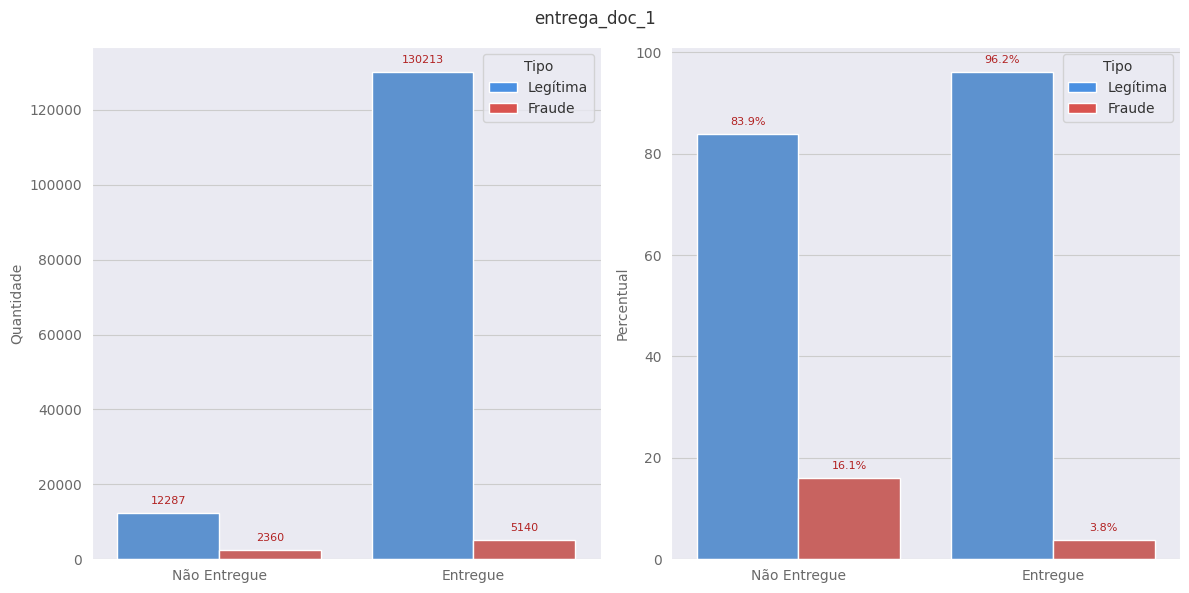

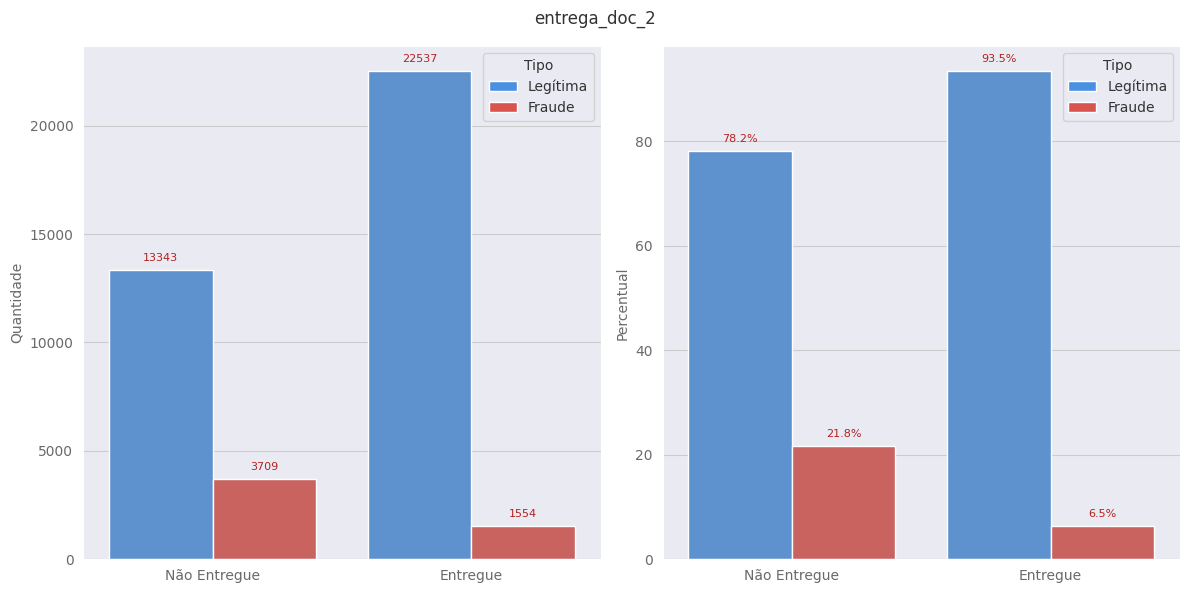

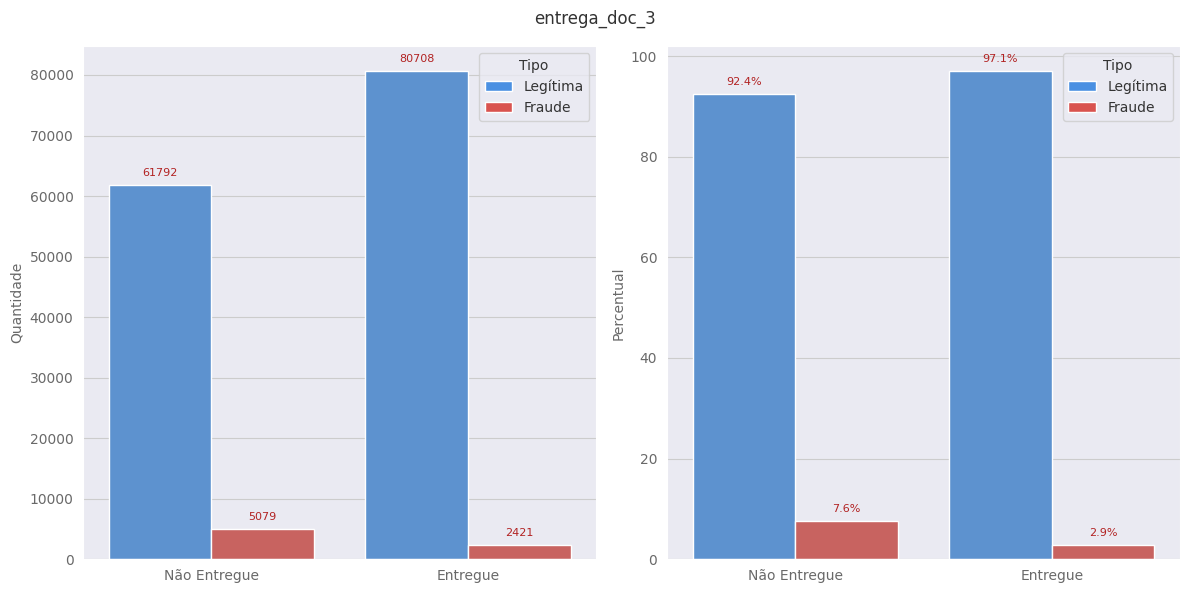

In [ ]:
# Comparativo entre os clientes que entregaram ou não os documentos e as compras legítimas X fraudadas,
# Alguma relação pode ser percebida entre um aumento de fraudes com a falta de entrega de algum dos documenntos?

cols = ['entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']

# Legendas
legenda_cores = [Patch(facecolor="#4A90E2", label="Legítima"), Patch(facecolor="#D9534F", label="Fraude")]

for col in cols:

    dist_abs = df.groupby(col)['fraude'].value_counts()
    dist_perc = df.groupby(col)['fraude'].value_counts(normalize= True) * 100

    df_freq = pd.DataFrame({'Absoluta': dist_abs, 'Percentual': dist_perc}).reset_index()
    df_freq.columns = [col, 'fraude', 'Absoluta', 'Percentual']

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    ax1, ax2 = axes
    fig.suptitle(col)

    # Plotting the count
    sns.barplot(data= df_freq, x= col, y= 'Absoluta', hue= 'fraude', palette= cor_fraudes, hue_order= [0, 1], ax= ax1)
    ax1.set_xlabel("")
    ax1.set_ylabel("Quantidade")
    ax1.set_xticks([0, 1])
    ax1.set_xticklabels(['Não Entregue', 'Entregue'])
    ax1.legend(handles= legenda_cores, title="Tipo")
    for container in ax1.containers:
        ax1.bar_label(container, fontsize=8, color= 'firebrick', padding=5)

     # Plotting the percentage
    sns.barplot(data= df_freq, x= col, y= 'Percentual', hue= 'fraude', palette= cor_fraudes, hue_order= [0, 1], ax= ax2)

    ax2.set_xlabel("")
    ax2.set_ylabel("Percentual")
    ax2.set_xticks([0, 1])
    ax2.set_xticklabels(['Não Entregue', 'Entregue'])
    ax2.legend(handles= legenda_cores, title="Tipo")
    for container in ax2.containers:
        ax2.bar_label(container, fontsize=8, color= 'firebrick', padding=5, fmt='%.1f%%')


    plt.tight_layout()
    plt.show()

  * Em todos os casos analisados, a falta de entrega dos documentos está associada a um aumento das fraudes. Faz sentido que um fraudador não  apresente documentos que possam identificá-lo, se ele já tem a intenção de cometer fraudes.

  * O documento 1 é o mais entregue, com mais de 130 mil transações onde consta a entrega e apenas cerca de 12 mil onde não consta a entrega. Entre as transações sem a entrega de documentos, 16,1% foram fraudes e entre as transações com entrega do documento, apenas 3,8% foram fraudes. A associação entre fraudes e não entrega da documentacão se confirma neste caso.

  * Em relação ao documento 2, a proporção dos que entregam para os que não entregam já apresenta uma diferença menor, aproximadamente 22500 transações constam com esta documentação entregue e 13300 não entregaram. Entre aqueles que não entregaram, 22,8% foram fraudes, enquanto entre as transações que entregaram, apenas 6,5% apenas forma fraudes. Novamente, a entrega do documento 2 confirma a associação entre a falta do documento e a ocorrência de fraudes.

  * O documento 3 foi o menos entregue, com aprox. 81 mil transações marcadas como entregue e quase 62 mil marcadas como não entregue. Dentre as transações que não entregaram, 7,6% foram fraudes, enquanto entre as transações que entregaram apenas 2,9% foram fraudadas.

  * De modo geral, há uma clara associação entre a não entrega da documentação com a prática de fraudes. Transações onde não consta a entrega dos documentos são de duas a cinco vezes mais fraudadas do que aquelas que são marcadas como entregues.

### Data da Compra

In [ ]:
# Avaliando período compreendido pelos dados

data_inicial = df['data_compra'].min()
data_final = df['data_compra'].max()

periodo = data_final - data_inicial

print(f'O período compreendido pelos dados deste conjunto é de {periodo}\n')

print(f'A data inicial deste conjunto de dados é {data_inicial}\n')
print(f'A data final deste conjunto de dados é {data_final}')


O período compreendido pelos dados deste conjunto é de 44 days 23:57:41

A data inicial deste conjunto de dados é 2020-03-08 00:02:15

A data final deste conjunto de dados é 2020-04-21 23:59:56


  * Estes dados foram coletados entre 08 de março e 21 de abril de 2020, um total de quase 45 dias.

In [ ]:
# Separando a data em novas colunas em um novo dataframe para análise em separado

df_time = df.copy()

df_time['month_data'] = df['data_compra'].dt.month

df_time['day_data'] = df['data_compra'].dt.day

df_time['day_week'] = df['data_compra'].dt.day_of_week

df_time['month_day_data'] = df['data_compra'].dt.strftime('%m-%d')

df_time['hour'] = df['data_compra'].dt.hour


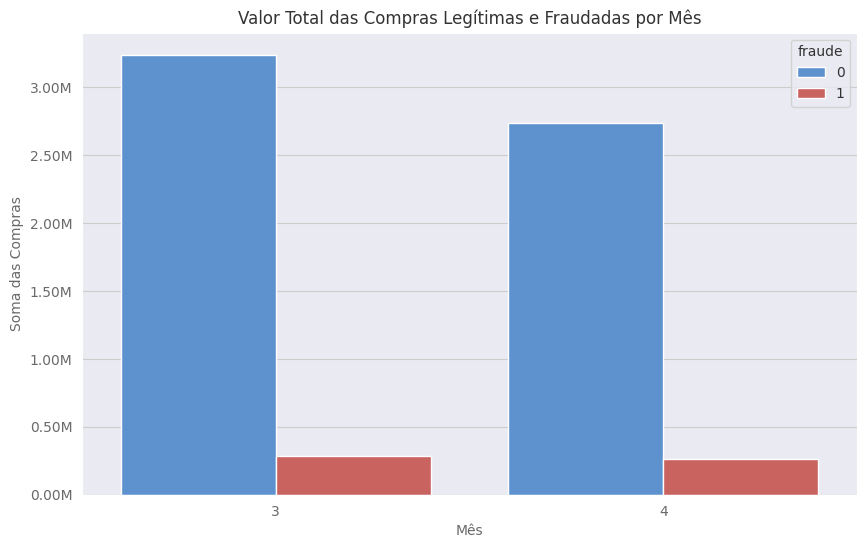

,month_data,fraude,valor_compra
0,3,0,3240261.90
1,3,1,282179.80
2,4,0,2740937.10
3,4,1,265091.32


In [ ]:
# Plotando compras fraudadas e legítimas em relação ao mês, para avaliar se há alguma diferença sigjnificativa entre os meses estudados

# Agrupando os dados por fraude e não fraude e somando os valores das compras
sum_month = df_time[['month_data', 'valor_compra', 'fraude']].groupby(['month_data', 'fraude']).sum().reset_index()

# Imprimindo um gráfico com a distribuição do valor total de compras
fig, ax= plt.subplots(figsize= (10,6))
ax = sns.barplot( data= sum_month, x= 'month_data', y= 'valor_compra', hue= 'fraude', palette= cor_fraudes)
plt.title('Valor Total das Compras Legítimas e Fraudadas por Mês')
plt.xlabel('Mês')
plt.ylabel('Soma das Compras')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000000) + 'M'))

plt.show()

sum_month

  * Podemos ver como a soma do valor de compras fraudadas não é muito diferente entre um mês e outro, mostrando que não houve preferência por fraudes em um mês específico.

In [ ]:
# Teste de hipótese para confirmar a intuição de que não há relação entre mês e fraudes

# Fazer uma crosstab entre mês e fraude
cross_table = pd.crosstab(df_time['month_data'], df_time['fraude'])

# Executar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(cross_table)

print("Valor de chi2:", chi2)
print("Valor p:", p, '\n')

if p < 0.05:
    print("Rejeitar a hipótese nula => Há uma relação estatisticamente significativa entre Mês e Fraude.")
else:
    print("Não rejeitar a hipótese nula => Mês e Fraude não apresentam uma relação estatisticamente significativa.")


Valor de chi2: 0.45471226672131904
Valor p: 0.5001056271366706 

Não rejeitar a hipótese nula => Mês e Fraude não apresentam uma relação estatisticamente significativa.


  * O p-value é maior que o threshold 0.05, por isso não há indícios de uma relação estatisticamente significativa entre o Mês e a realização de Fraudes, confirmando a intuição vista a partir do gráfico acima.

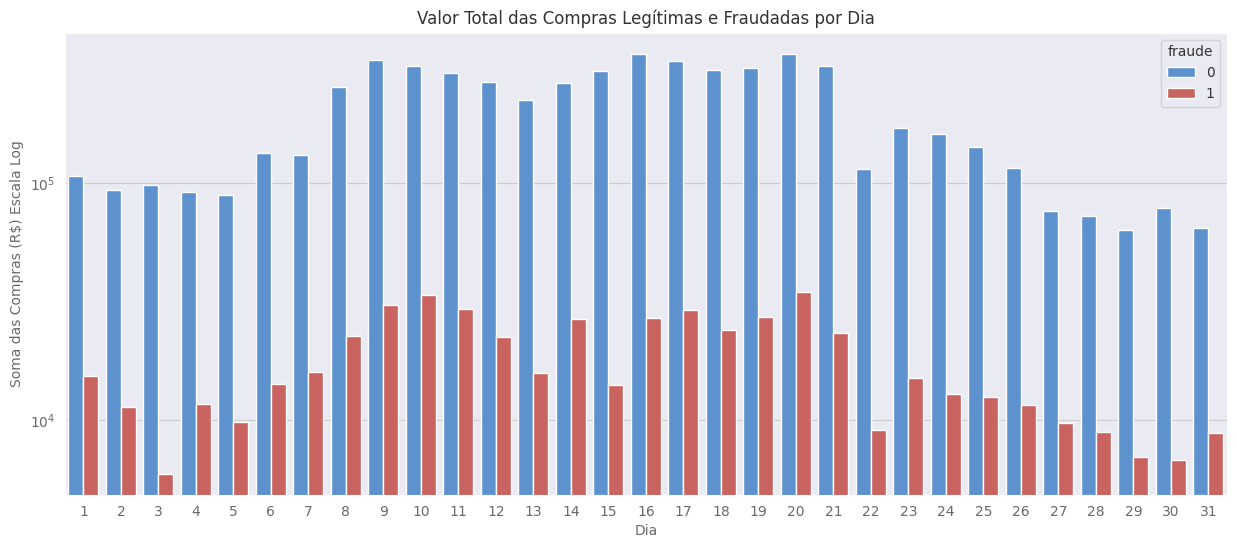

In [ ]:
# Realizar o mesmo procedimento, agora em relação ao dia do mês. Há algum dia com maior incidência de fraudes?
# Agrupando os dados por fraude e não fraude e somando os valores das compras

sum_day = df_time[['day_data', 'valor_compra', 'fraude']].groupby(['day_data', 'fraude']).sum().reset_index()

# Imprimindo um gráfico com a distribuição do valor total de compras

fig, ax= plt.subplots(figsize= (15,6))
ax = sns.barplot(data= sum_day, x= 'day_data', y= 'valor_compra', hue= 'fraude', palette= cor_fraudes)
plt.title('Valor Total das Compras Legítimas e Fraudadas por Dia')
plt.xlabel('Dia')
plt.ylabel('Soma das Compras (R$) Escala Log')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))
ax.set_yscale('log')
plt.show()

#sum_day


  * Aparentemente também não há uma relação entre o dia das compras e a realização de fraudes.

In [ ]:
# Teste de hipótese para confirmar a intuição de que não há relação entre dia e fraudes
# Fazer uma crosstab entre dia e fraude
cross_table = pd.crosstab(df_time['day_data'], df_time['fraude'])

# Executar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(cross_table)

print("Valor de chi2:", chi2)
print("Valor p:", p, '\n')

if p < 0.05:
    print("Rejeitar a hipótese nula => Há uma relação estatisticamente significativa entre Dia e Fraude.")
else:
    print("Não rejeitar a hipótese nula => Dia e Fraude não apresentam uma relação estatisticamente significativa.")


Valor de chi2: 176.07910490044085
Valor p: 1.3308511585064855e-22 

Rejeitar a hipótese nula => Há uma relação estatisticamente significativa entre Dia e Fraude.


  * O teste chi2 evidencia que a intuição em relação ao gráfico está incorreta. Há indícios para afirmar que existe uma relação estatisticamente significativa entre o dia e a existência de fraudes.

  * O gráfico acima evidencia uma maior quantidade de fraudes na segunda e na terceira semana. Possivelmente esta é uma associação entre data e existência de fraudes.

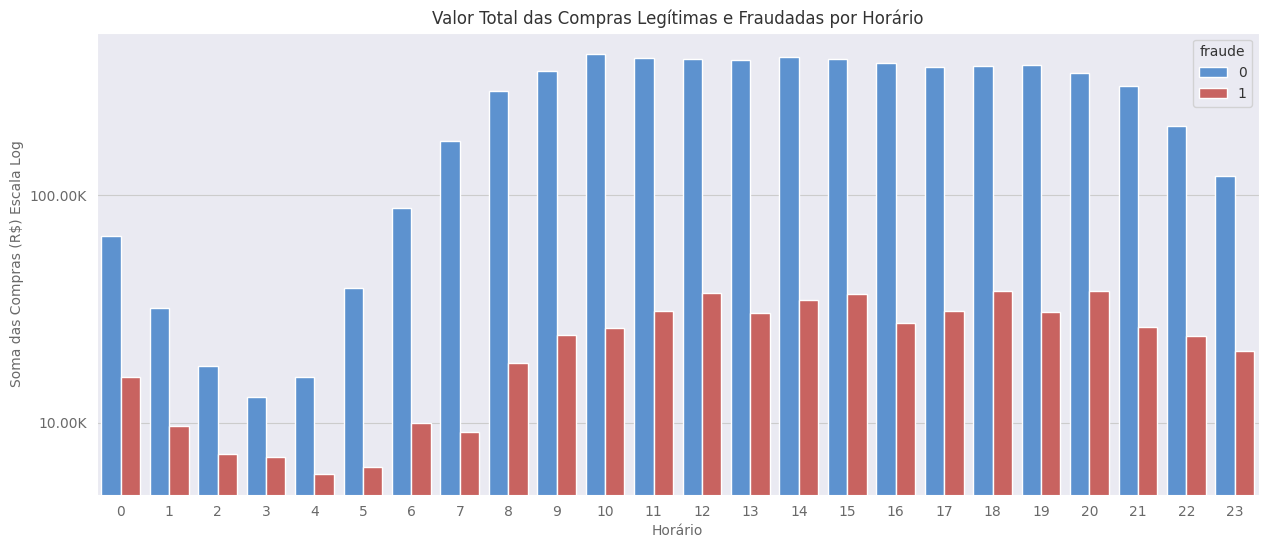

In [ ]:
# Realizar o mesmo procedimento, agora em relação ao horário. Há algum horário com maior incidência de fraudes?
# Agrupando os dados por fraude e não fraude e somando os valores das compras

sum_hour = df_time[['hour', 'valor_compra', 'fraude']].groupby(['hour', 'fraude']).sum().reset_index()

# Imprimindo um gráfico com a distribuição do valor total de compras

fig, ax= plt.subplots(figsize= (15,6))
ax = sns.barplot(data= sum_hour, x= 'hour', y= 'valor_compra', hue= 'fraude', palette= cor_fraudes)
plt.title('Valor Total das Compras Legítimas e Fraudadas por Horário')
plt.xlabel('Horário')
plt.ylabel('Soma das Compras (R$) Escala Log')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.2f}'.format(x/1000) + 'K'))

plt.show()

#sum_hour


  * O gráfico acima apresenta uma tendência de diminuição da quantidade de fraudes durante a madrugada e um aumento durante o horário comercial, acompanhando a tendência evidente de haver mais compras legítimas no horário comercial e período da noite, com uma grande diminuição na madrugada.

  * Porém proporcionalmente, durante a madrugada se observa mais ocorrências de fraudes. A razão compras legítimas / fraudes é maior na madrugada e menor no horário comercial.

In [ ]:
# Teste de hipótese para confirmar a intuição de que há relação entre horário e fraudes
# Fazer uma crosstab entre hora e fraude
cross_table = pd.crosstab(df_time['hour'], df_time['fraude'])

# Executar o teste do qui-quadrado
chi2, p, _, expected = chi2_contingency(cross_table)

print("Valor de chi2:", chi2)
print("Valor p:", p, '\n')

if p < 0.05:
    print("Rejeitar a hipótese nula => Há uma relação estatisticamente significativa entre Hora e Fraude.")
else:
    print("Não rejeitar a hipótese nula => Hora e Fraude não apresentam uma relação estatisticamente significativa.")


Valor de chi2: 841.6593861727897
Valor p: 5.3030288311866235e-163 

Rejeitar a hipótese nula => Há uma relação estatisticamente significativa entre Hora e Fraude.


  * O teste chi2 confirma a intuição vista no gráfico de que há evidências para afirmar que existe uma relaçao estatisticamente significativa entre o horário e a realização de fraudes.

**Conclusão sobre análise de relação entre data e fraude**

  * Apesar de vermos através dos testes estatísticos que há uma relação significante entre dia e horário com a realização de fraudes, os dados refletem um período de tempo pequeno (pouco mais de um mês), não considero suficiente para podermos avaliar a evolução do comportamento das fraudes ao longo do tempo.

  * Não irei elaborar uma modelagem que trabalhe com séries temporais, por isso não será interessante para o modelo de classificação incluirmos estas features de data. Os fraudadores podem perceber que as compras ilegítimas estão sendo barradas em determinada hora do dia ou dia do mês e simplesmente utilizarem outros horários ou dias para cometerem as fraudes, o que iria enfraquecer a efetividade do modelo em classificar assertivamente as compras.

### Colunas de Scores

  * Apesar de não sabermos o significado de cada um destes scores, vale investigar um pouco mais a fundo se há alguma associação entre cada um destes scores e a existência ou não de fraudes.

  * Avaliar a distribuição destas variáveis é um primeiro passo para compreendê-las, por isso irei investigar através de histogramas como a distribuição de cada coluna se comporta.

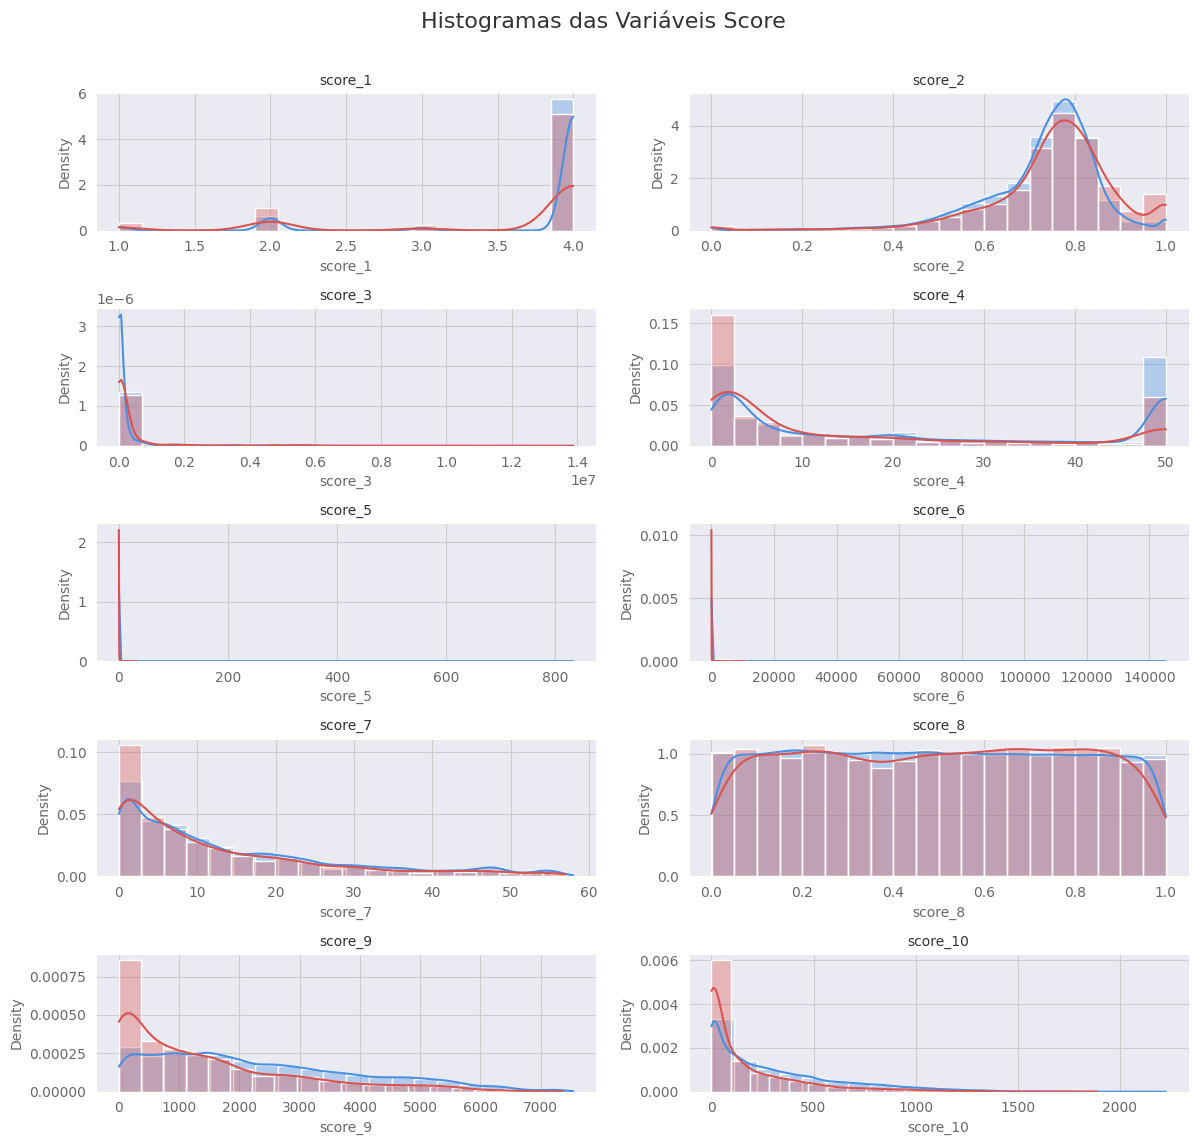

In [ ]:
# Plotar histogramas para cada coluna score para identificar as distribuições

score_cols = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5',
               'score_6', 'score_7', 'score_8', 'score_9', 'score_10']

fig, axes = plt.subplots(5, 2, figsize=(12, 12))

# Loop para plotar os histogramas
for i, ax in enumerate(axes.ravel()):
    if i < len(score_cols):
        col = score_cols[i]

        sns.histplot(df[df['fraude'] == 0][col], bins=20, kde = True, stat= 'density', ax= ax, alpha= 0.35, color= cor_fraudes[0])

        sns.histplot(df[df['fraude'] == 1][col], bins=20, kde = True, stat= 'density', ax= ax, alpha= 0.35, color= cor_fraudes[1])

        ax.set_title(col, fontsize= 10)

fig.suptitle("Histogramas das Variáveis Score", fontsize= 16)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()


**Observações Sobre as Distribuições**

  * A coluna **score_1** possui apenas 4 valores distintos, podemos considerá-la como uma variável categórica e não numérica. Mesmo assim, é possível perceber uma maior concentração de dados no score 4.

  * A coluna **score_2** apresenta uma cauda à esquerda e uma maior concentração de dados à direita (assimetria negativa), em scores mais altos.

  * A coluna **score_3** apresenta uma assimetria à esquerda (positiva), com cauda muito longa e maior parte dos valores na faixa de scores baixos.

  * A coluna **score_4** apresenta uma distribuição bimodal, com muitos valores concentrados nas faixas alta e baixa do score e o restante dos dados distribuídos ao longo do intervalo de forma quase uniforme.

  * A coluna **score_5** e **score_6** apresentam distribuição altamente enviesada para a esquerda, com a quase totalidade dos valores na faixa baixa dos scores.

  * A coluna **score_7** apresenta uma distribuição assimétrica positiva à esquerda, com o restante dos dados dispersos ao longo do intervalo de valores.

  * A coluna **score_8** apresenta uma distribuição quase uniformemente distribuída, não acrescenta assim muita informação à modelagem.

  * A coluna **score_9** possui uma distribuição enviesada à esquerda, porém com uma dispersão decaindo de forma quase linear até as faixas mais altas de valor.

  * A coluna **score_10** apresenta uma distribuição enviesada positiva, com maior parte dos dados em valores de score baixos e uma dispersão quase exponencial através do intervalo até faixas de score alto.

**Transformação e Imputação dos Dados Faltantes**

  * Coluna score_1, por ser categórica pode ser encodada. Como não sabemos avaliar se a importância da categoria segue ou não o ordem numérica (isto é: se ter score 1 é melhor ou pior do que um score 4) uma boa abordagem, seria usar um encoder do tipo one-hot encoder, que irá dar um peso numérico igual para tods as categorias.

  * As colunas score_2, 4, 7, 9 e 10 apresentam distribuições não normais (não Gaussianas) e por isso uma boa forma de imputar valores faltantes é usando a mediana, que é menos sensível a outliers do que a média.

  * As colunas score 3, 5 e 6 possuem a grande maioria dos dados próximos a zero. A trasformação logarítmica pode ser uma abordagem possível, já que irá reduzir a assimetria e ajudar a normalizar as distribuições, permitindo imputar dados de forma mais eficiente no caso de dados faltantes e permitindo ao modelo de Machine Learning interpretar melhor estes dados.

  * Todas as colunas score (exceto a score_1, que é categórica) podem ser normalizadas para que os intervalos de valor variem apenas entre 0 e 1, já que não há valores negativos de score.

### Correlação Entre as Variáveis

In [ ]:
# Calcular assoiação chi quadrado entre entrega doc 1, 2 e 3 e fraude

def chi2_fraude(df, col, target='fraude'):

  """
  Calcula X2, p-value  e coef phi, que mede a força da associação
  """
  cont_tab = pd.crosstab(df[col], df[target])
  chi2, p, dof, _ = chi2_contingency(cont_tab, correction= False)

  n = cont_tab.values.sum()
  phi = np.sqrt(chi2 / n)

  return chi2, p, phi


In [ ]:
# Aplica função

cols= ['entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']

results = []

for col in cols:
  chi2, p, phi = chi2_fraude(df, col, target= 'fraude')
  results.append({'variável': col,
                  'X^2': chi2,
                  'p-value': p,
                  'phi': phi})
  if p < 0.05:
    print(f'p-value {col} < 0.05 => Associação estatisticamente significativa \n')
  else:
    print(f'p-value {col} > 0.05 => Associação não é estatisticamnte significativa \n')


chi2_df = pd.DataFrame(results)

print(chi2_df)


p-value entrega_doc_1 < 0.05 => Associação estatisticamente significativa 

p-value entrega_doc_2 < 0.05 => Associação estatisticamente significativa 

p-value entrega_doc_3 < 0.05 => Associação estatisticamente significativa 

        variável          X^2  p-value       phi
0  entrega_doc_1  4219.909400      0.0  0.167728
1  entrega_doc_2  2095.345615      0.0  0.225673
2  entrega_doc_3  1710.927028      0.0  0.106800


In [ ]:
# Calcular o coeficiente de correlação point bi serial entre as variáveis e a variável fraude

# Fraude é uma variável binária e o restante são variáveis numéricas contínuas

correlations = {}

num_cols = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6',
            'score_7', 'score_9', 'score_10', 'valor_compra']

# Cálculo correlação de Pearson
corr_pearson = df[num_cols].corr()

# Cálculo correlação Bi-serial
correlations = {}

for col in num_cols:

  x = pd.to_numeric(df[col], errors= 'coerce')
  y = df['fraude'].astype(int)

  mascara = np.isfinite(x)
  r, p = pointbiserialr(x[mascara], y[mascara])
  correlations[col] = {'Point_biserial': r, 'p_value': p}

biserial_df = pd.DataFrame.from_dict(correlations, orient= 'index')


# Cria um df combinado (quadrado) com uma linha extra para corr Bi-serial
combinado = corr_pearson.copy()
combinado['fraude'] = np.nan # cria nova coluna
combinado.loc['fraude'] = np.nan # cria nova linha

# Preenche fraude X numéricas com Bi-serial
for col in num_cols:
  r_pb = biserial_df.loc[col, 'Point_biserial']
  combinado.loc['fraude', col] = r_pb
  combinado.loc[col, 'fraude'] = r_pb

# Criando inhha e coluna extra para as correlaçoes chi2
for col, phi in zip(chi2_df['variável'], chi2_df['phi']):
  combinado[col] = np.nan # cria coluna
  combinado.loc[col, 'fraude'] = np.nan # cria linha

  # preenche fraude x docs
  combinado.loc['fraude', col] = phi
  combinado.loc[col, 'fraude'] = phi

combinado.loc['fraude', 'fraude'] = 1 # marcando diagonal


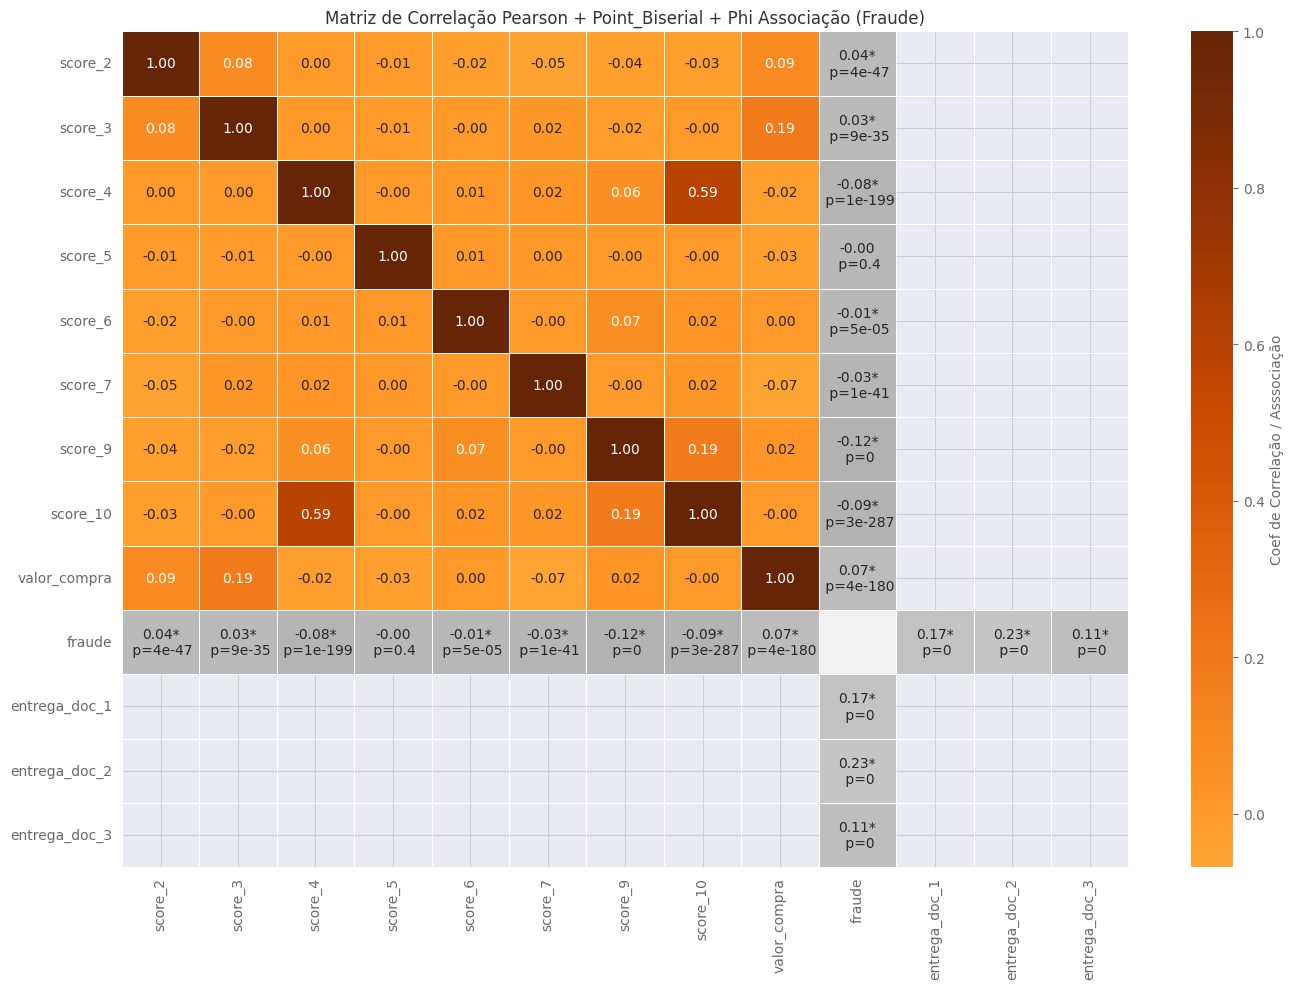

In [ ]:
# Plotando correlação combinada Pearson e Bi-Serial em heatmap

mask_pb = np.ones_like(combinado, dtype= bool)
mask_pb[combinado.index.get_loc('fraude'), :] = False
mask_pb[:, combinado.columns.get_loc('fraude')] = False

mask_prs = ~mask_pb

# Anotações para a correlação bi-serial com p-value
def make_annot(i, j):
  if i == 'fraude' and j == 'fraude':
    return ''

  if i == 'fraude' or j == 'fraude':
    col = j if i == 'fraude' else i
    if col in chi2_df['variável'].values:
      phi = chi2_df.set_index('variável').loc[col, 'phi']
      p = chi2_df.set_index('variável').loc[col, 'p-value']
      mark = '*' if p <0.05 else ''
      return f'{phi:.2f}{mark}\n p={p:.1g}'

    else:
      r = biserial_df.loc[col, 'Point_biserial']
      p = biserial_df.loc[col, 'p_value']
      mark = '*' if p <0.05 else ''

      return f"{r:.2f}{mark}\n p={p:.1g}"

  else:
    return f"{combinado.loc[i, j]:.2f}"

annot_text = combinado.copy().astype(str)
for i in combinado.index:
  for j in combinado.columns:
    annot_text.loc[i, j] = make_annot(i, j)


# Plotando heatmap pearson
plt.figure(figsize = (14, 10))

sns.heatmap(combinado, mask= mask_prs,
            annot = annot_text.values,
            fmt = '',
            cmap = "YlOrBr",
            center= 0,
            linewidths= 0.5,
            cbar_kws= {'label': 'Coef de Correlação / Asssociação'})

grey_cmap = sns.light_palette('gray', as_cmap= True, reverse= True)
sns.heatmap(combinado, mask = mask_pb,
            cmap = grey_cmap,
            center= 0,
            annot = annot_text.values,
            fmt= '',
            linewidths = 0.5,
            cbar = False)

plt.title("Matriz de Correlação Pearson + Point_Biserial + Phi Associação (Fraude)")

plt.tight_layout()
plt.show()



**Análise das Correlaçcões**

  * A correlação de Pearson mede a proporcionalidade entre uma variável e utra. Grosso modo, é uma razão matemática ajustada entre as médias de cada variável que varia de -1 a 1. Se uma correlação é positiva, a relação entre as variáeis é diretamente proporcional. Se a correlação é negativa, então a relação entre as variáveis é inversamente proporcional. Já se a correlação é igual a zero, então não há proporcionalidade entre as variáveis.

  * A correlação de Pearson consegue captar relações entre variáveis numéricas contínuas. Já a relacão de Sperman é capaz de captar relações entre variáveis numéricas ordinais, através de ranking.

  * Já a correlação Ponto Bi-Serial mede uma relação estatística entre uma variável categórica binária e uma variável numérica contínua.

  * Neste caso de estudo, há uma necessidade de utilizar uma composição das correlações mais adequadas para cada tipo de variável. A variável target 'Fraude' é uma variável categórica binária, enquanto parte das demais variáveis possivelmente correlacionadas são numéricas e outra parte são categóricas.

  * Por isso este heatmap mostra as correlações entre as variáveis numéricas em cores tons de laranja, enquanto o 'L' inferior em cinza é uma plotagem da variável 'Fraude' ussando a correlação Ponto Bi-Serial.

  * Não há uma correlação tão forte neste dataset. A mais evidente é a correlação positiva de 0.59 entre o score 10 e o score 4. Mesmo assim não é considerada uma correlação forte suficiente pra atrapalhar a modelagem de ML.

  * Já em relação às correlações bi-seriais da variável 'fraude', todas são muito pequenas, apesar de o p-value delas ser na maioria das vezes considerado estatisticamente sigificativo (p-value < 0.05). Este valores tão baixos de correlação estão ligados  ao desbalanceamento da classe minoritária. Toda essa análise de correlação não traz muitos  insights úteis ao entendimento do negócio, mas são importantes pra evitar features auto-correlacionadas em uma futura modelagem de Machine Learning.

  * A associação entre as variáveis entrega dos documentos 1, 2 e 3 com a variável fraude foi calculada usando teste chi-quadrado para medir a força da associação (phi) e o p-value que confirma ou refuta a hipótese de associação. Através dos valores calculados e do heatmap, fica confirmado que há sim uma associação estatisticamente significativa, ainda que a força não seja tanta, entre a entrega ou não dos documentos e o cometimento de fraudes.
  <br>
  <br>


## Pré Processamento de Dados

  * Encerrada a análise exploratória, vou fazer uma cópia nova do dataset bruto, realizar a divisão treino/teste, criar funções para realizar o pré-processamento e, finalmente, criar uma função pipeline para executar todo o pré-processamento.

  * O pipeline de pré processamento deve ser aplicado nos dados de treino e de teste em separado, porém exatamente da mesma forma. Isso garante que qualquer sistema de machine learning que for utilizado encontre as mesmas condições (colunas, escalas, etc) tanto nos dados de treino, quanto nos dados de teste.

  * Etapa 1 => Divisão dos dados em treino e teste
  
  * Etapa 2 => Remover colunas desnecessárias
  
  * Etapa 3 => Imputar dados nulos e tratar missings

  * Etapa 4 => Encodar colunas

  * Etapa 5 => Normalização ou Standardização das colunas

  * Etapa 6 => Criar um pipeline que unifique todas estas etapas e esteja pronto para usar com algoritmos de ML e processos dde validação cruzada, como K-Fold ou Grid-search CV.

In [ ]:
# Fazendo uma cópia do dataset inteiro do início.
# Isso Garante que eventuais tratamentos realizados durante a etaa de EDA não sejam transmitidos para a etapa de pré procesamento

df = df_pre.copy()

In [ ]:
df.columns

Index(['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
       'pais', 'score_7', 'produto', 'categoria_produto', 'score_8', 'score_9',
       'score_10', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3',
       'data_compra', 'valor_compra', 'score_fraude_modelo', 'fraude'],
      dtype='object')

In [ ]:
df.shape

(150000, 20)

### Etapa 01 => Data Split

In [ ]:
# Aplicando função train / test split para divisão dos dados de treino e de teste

X = df.drop(columns= ['fraude']) # Drop da coluna target
y = df['fraude'] # Apenas o target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.25, stratify= y, random_state= 71)

print(f'Shape do df original, antes da divisão: {df.shape}\n')

print(f'Shape do X_train, dataset de treino: {X_train.shape}\n')
print(f'Shape do y_train, coluna target do treino: {y_train.shape}\n')

print(f'Shape do X_test, dataset de teste: {X_test.shape}\n')
print(f'Shape do y_test, coluna target do teste: {y_test.shape}\n')

Shape do df original, antes da divisão: (150000, 20)

Shape do X_train, dataset de treino: (112500, 19)

Shape do y_train, coluna target do treino: (112500,)

Shape do X_test, dataset de teste: (37500, 19)

Shape do y_test, coluna target do teste: (37500,)



### Etapa 2 => Removendo Colunas Desnecessárias

In [ ]:
# Função dropper

class ColumnDropper(BaseEstimator, TransformerMixin):
  def __init__(self, cols_to_drop):
    self.cols_to_drop = cols_to_drop
    self.is_fitted_ = False

  def fit(self, X, y=None):
    self.is_fitted_ = True
    return self

  def transform(self, X):
    if not self.is_fitted_:
      raise RuntimeError("Dropper was not fitted")
    return X.drop(columns= self.cols_to_drop, errors= 'ignore')



### Etapa 3 => Imputação de Valores e Tratamento de Missings

In [ ]:
# Função imputer

class CustomImputer(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.median_cols = ['score_2', 'score_3', 'score_4', 'score_6', 'score_9', 'score_10']
    self.median_imputer = SimpleImputer(strategy= 'median')
    self.pais_imputer = SimpleImputer(strategy= 'constant', fill_value= 'outros')
    self.doc_imputer = SimpleImputer(strategy= 'constant', fill_value= 0)
    self.is_fitted_ = False

  def fit(self, X, y=None):
    self.pais_imputer.fit(X[['pais']])
    self.median_imputer.fit(X[self.median_cols])
    self.doc_imputer.fit(X[['entrega_doc_2']])
    self.is_fitted_ = True
    return self

  def transform(self, X):
    if not self.is_fitted_:
      raise RuntimeError("Imputer was not fitted")

    X_ = X.copy()
    X_['pais'] = self.pais_imputer.transform(X_[['pais']]).ravel()
    X_[self.median_cols] = self.median_imputer.transform(X_[self.median_cols])
    X_['entrega_doc_2'] = self.doc_imputer.transform(X_[['entrega_doc_2']]).ravel()
    return X_


### Etapa 4 => Transformações em Colunas e Encodings

In [ ]:
# Função pais encoder

class PaisEncoder(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.ohe = OneHotEncoder(handle_unknown= 'ignore', drop= None, sparse_output=False)
    self.expected_features = None
    self.is_fitted_ = False

  def _map(self, s):
    return s.apply(lambda x: 'BR' if x == 'BR' else 'AR' if x == 'AR' else 'outros')

  def fit(self, X, y=None):
    mapped = self._map(X['pais'].fillna('outros')).to_frame()
    self.ohe.fit(mapped)
    self.expected_features = self.ohe.get_feature_names_out(['pais'])
    self.is_fitted_ = True
    return self

  def transform( self, X):
    if not self.is_fitted_:
      raise RuntimeError("Encoder was not fitted")

    X_ = X.copy()
    mapped = self._map(X_['pais'].fillna('outros')).to_frame()
    arr = self.ohe.transform(mapped)
    ohe_df = pd.DataFrame(arr, columns= self.expected_features, index= X_.index)

    X_ = X_.drop(columns=['pais']).join(ohe_df)

    return X_


In [ ]:
# Função WOE encoder

class WoEEncode(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols
    self.encoder = WOEEncoder(cols= self.cols)
    self.is_fitted_ = False

  def fit(self, X, y):
    self.encoder.fit(X, y)
    self.is_fitted_ = True
    return self

  def transform(self, X):
    if not self.is_fitted_:
      raise RuntimeError("WOE was not fitted")

    return self.encoder.transform(X)


#### Target Encoding ou Weight of Evidence Encoder?

**Target Encoding**

  * Target Encoding (ou Mean eEncoding) funciona calculando um valor para cada categoria com base na média do target presente nela. Este encoder é usado para lidar com cardinalidade média a elevada, captura bem a relação entre as categorias e o target, levando a uma correlação boa. Porém é mais suscetível a overfitting e funciona melhor com casos de cardinalidade moderada.
<br>
<br>
Fórmula básica:

$$TE(x_i) = \frac {1}{N_i} \sum_ {j=1}^{N_i} y_i $$

Onde:

$N_i = \text {Num de amostras da categoria  } x_i$

$y_i = \text {Valores da variável alvo para a categoria  } x_i$
<br>
<br>
Target Encoder também pode ser usado com um parâmetro de suavização (smoothing), neste caso a fórmula fica:

$$TE_{\text {smooth}}x_i = \frac {N_ . \mu_{x_i} + m . \mu} {n_i + m} $$

Onde:

$\mu_{x_i} = \text {Média da variável alvo para a categoria  } x_i$

$\mu = \text {Média global da variável alvo} $

$ n_i = \text {Num de amostras da categoria } x_i $

$m = \text {Parâmetro de Suavização} $

Quanto maior o parâmetro $m$, mais próxima a média da categoria fica da média global. No limite, todas as categorias ficariam com a mesma média global.
<br>
<br>
  * Ou seja, de modo genérico é  média da variável alvo para cada categoria. Assim se tivermos mil categorias, teremos mil diferentes médias atribuídas, uma pra cada categoria.
<br>
<br>

**Weight of Evidence**

  * Weight of evidence e uma estratégia de encoding que se baseia na probabilidade de haver ou não haver a variável alvo dentro de cada categoria. Por exemplo, no nosso caso de fraude, as categorias são transformadas em valores numéricos baseados na proporção entre transações legítimas e transações fraudadas.

Sua fórmula é dada por:

$$WoE(x_i) = ln. \left(\frac {\text {Taxa de legítimas em } x_i} {\text {Taxa de fraudes em } x_i}\right) $$

Onde:

$ln$ = Logaritmo natural

(centraliza a escala em torno de 0, podemos interpretar como: categoria que "favorece" fraudes => sinal negativo e categoria que "favorece" transações legítimas => sinal positivo).

Um WoE igual a zero seria uma categoria com a mesma quantidade de fraudes e de compras legítimas.
<br>
<br>
De forma mais detalhada, a fórmula de WoE é dada por

$$ WoE(x_i) = ln. \left(\frac {B_i / B} {M_i / M}\right) => ln. \left(\frac {B_I . M}{M_i. B} \right)$$

Onde:

$B_i = \text {Num de transações legítimas na categoria  } x_i$

$B = \text {Total de transações legítimas}$

$M_i = \text {Num de fraudes na categoria } x_i$

$M = \text {Total de fraudes}$

<br>
<br>

**Conclusão**

  * No caso deste estudo sobre detecção e prevenção de fraudes, o método de Weight of Evidence se mostra mais adequado, pois capta com mais precisão a relação entre as categorias que possuem mais ou menos fraudes. Como vimos na EDA, as fraudes se concentram em aproximadamente 10 a 15% das categorias, havendo muito poucos casos nas outras categorias de forma geral.

  * Mesmo assim, o método de WoE é capaz de calcular e dar peso diferente para cada categoria, dispensando outros tratamentos, como por exemplo, filtrar as 1000 categorias mais importantes e transformar o restante em uma única categoria, similar ao que foi realizado na coluna país.

In [ ]:
# Função OHE docs

class OHEDocs(BaseEstimator, TransformerMixin):
  def __init__(self):
    self.doc_cols = ['score_1', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3']
    self.ohe = OneHotEncoder(handle_unknown= 'ignore', sparse_output=False)
    self.is_fitted_ = False

  def fit(self, X, y= None):
    self.ohe.fit(X[self.doc_cols].astype(str))
    self.feature_names_ = self.ohe.get_feature_names_out(self.doc_cols)
    self.is_fitted_ = True
    return self

  def transform(self, X):
    if not self.is_fitted_:
      raise RuntimeError("OHEDocs was not fitted")

    X_ = X.copy()
    arr = self.ohe.transform(X_[self.doc_cols].astype(str))
    ohe_df = pd.DataFrame(self.ohe.transform(X_[self.doc_cols].astype(str)), columns= self.feature_names_, index= X_.index)
    X_ = X_.drop(columns= self.doc_cols).join(ohe_df)

    return X_


In [ ]:
# Função missing_flags

class MissingFlags(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols
    self.is_fitted_ = False

  def fit(self, X, y=None):
    self.is_fitted_ = True
    return self

  def transform(self, X):
    if not self.is_fitted_:
      raise RuntimeError("MissingFlags was not fitted")

    X_ = X.copy()
    for col in self.cols:
      X_[f'is_missing_{col}'] = X_[col].isna().astype(int)
    return X_


### Etapa 5 => Normalização

  * Como estes dados não apresentam valores negativos, o ideal é usar Min-Max scaler, já que ele não altera a distribuição dos dados, apenas "achata" os valores para uma escala comum, variando de 0 a 1.

  * Standard Scaler (ou Z-score) centraliza os dados com média 0 e desvio padrão 1, ou seja, os dados variam de -1 a 1, centralizados em 0.

  * Robust Scaler utiliza mediana e intervalo inter quartil, é bem robusto para escalar dados que possuem muitos outliers.

  * Convencionalmente, modelos com base em Árvore podem lidar com dados em diferentes escalas sem problemas. Mas apesar de manter os dados na escala original ajudar na interpretabilidade do modelo, no caso de usarmos feature_importances (propriedade muito útil para selecionar as melhores features de um modelo), pode ser melhor ter todos os intervalos das features dentro de uma escala comum.

In [ ]:
# Função min max scaler

class MinMaxScale(BaseEstimator, TransformerMixin):
  def __init__(self, cols):
    self.cols = cols
    self.scaler = MinMaxScaler()
    self.is_fitted_ = False

  def fit(self, X, y= None):
    self.scaler.fit(X[self.cols])
    self.is_fitted_ = True
    return self

  def transform(self, X):
    if not self.is_fitted_:
      raise RuntimeError("MinMaxScale was not fitted")

    X_ = X.copy()
    X_[self.cols] = self.scaler.transform(X_[self.cols]).astype(float)
    return X_



### Etapa 6 => Pipeline Pré Processamento

In [ ]:
# Pipeline sklearn

cols_to_drop = ['data_compra', 'produto', 'score_8', 'score_fraude_modelo']

missing_cols = ['score_2', 'score_3', 'score_4', 'score_6', 'score_9', 'score_10', 'entrega_doc_2']

woe_cols = ['categoria_produto']

norm_cols = ['score_2', 'score_3', 'score_4', 'score_5', 'score_6',
             'score_7', 'score_9', 'score_10', 'valor_compra']


pre_pipe = Pipeline(steps = [
    ('drop', ColumnDropper(cols_to_drop)),
    ('imputer', CustomImputer()),
    ('pais_encoding', PaisEncoder()),
    ('miss_flags', MissingFlags(missing_cols)),
    ('docs_ohe', OHEDocs()),
    ('woe', WoEEncode(woe_cols)),
    ('normalize',MinMaxScale(norm_cols)),
])

In [ ]:
# Aplicar Pipeline no modelo teste

pipe = Pipeline(steps= [
    ('pre-processing', pre_pipe),
    ('model clf', LogisticRegression(max_iter= 1000))
])

In [ ]:
# Rodar modelo completo

pipe.fit(X_train, y_train)

# Verificação após pipe.fit()
if hasattr(pipe.named_steps['model clf'], 'n_iter_'):
    print(f"O modelo convergiu em {pipe.named_steps['model clf'].n_iter_[0]} iterações")
else:
    print("O modelo não registrou iterações - possivelmente não convergiu")

print(f'Pipeline foi fitado com sucesso!')

# y_pred => fazendo previsão de y_test
y_pred = pipe.predict(X_test)
print(f'Executando o  predict...')

y_pred_proba = pipe.predict_proba(X_test)
print(f'Executando o  predict_proba...')


O modelo convergiu em 43 iterações
Pipeline foi fitado com sucesso!
Executando o  predict...
Executando o  predict_proba...


In [ ]:
# Conferindo resultado y_pred e y_pred_proba do modelo

print(y_pred, '\n')

print(y_pred_proba)

[1 0 0 ... 0 0 0] 

[[0.45252485 0.54747515]
 [0.95714503 0.04285497]
 [0.99229476 0.00770524]
 ...
 [0.93444226 0.06555774]
 [0.99589923 0.00410077]
 [0.96324881 0.03675119]]
